# Desafio UFMG - Kaggle

# Carregando bibliotecas

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math
from sklearn.cluster import KMeans

FLAG_CARREGAR_FALTANTES_PREENCHIDOS = False

# Definição dos métodos

In [2]:
#Vasculhara todas as linhas do dataset procurando nas colunas
#que indicam os ids dos amigos presentes no momento do post.
#Naturalmente, indica se o id indicado estava presente
#com algum colega que originou o post.

#retorno: True/False, coordenada lat e long
def procura_id(id, dataset):
    
    #Existem usuarios que estao estao 2 ou mais lugares ao mesmo tempo
    #Por exemplo, usuario X posta uma mensagem dizendo que o usuario A 
    #esta com ele. No entanto, o usuario Y tambem posta uma mensagem NO
    #MESMO INSTANTE e diz que o usuario A tambem esta com ele.
    #Vale dizer que A e B nao estao na mesma coordenada geografica
    qtde_resultados_encontrado = 0 
    resultado = {"encontrado": False, "coordenadas":[0,0]}
    
    for indice,x in dataset.iterrows():

        if(
          (x['a']==id) | 
          (x['b']==id) |
          (x['c']==id) |
          (x['d']==id) |
          (x['e']==id) |
          (x['f']==id) |
          (x['g']==id) |
          (x['h']==id) |
          (x['i']==id)):
            #print("DF COMPLETO:", indice, "\nusuario: ", id, "\nrow: ", x )
            qtde_resultados_encontrado = qtde_resultados_encontrado + 1
 
            if(qtde_resultados_encontrado>1):
                #print("Encontrando numa outra posicao: ", x['gps_lat'], "  ", x['gps_long'])
                break #encontrou mais de 1 posicao do usuario id. Saia do loop e nao retorne resultado.

            if(qtde_resultados_encontrado==1): #se achar somente 1 resultado, entao legal!
                #print("Encontrando NA PRIMEIRA posicao: ", x['gps_lat'], "  ", x['gps_long'])
                resultado = {"encontrado": True, "coordenadas": [x['gps_lat'], x['gps_long']]}
            #return {"encontrado": True, "coordenadas": [x['gps_lat'], x['gps_long']]}
    
    
    if(qtde_resultados_encontrado>1): #Se encontrar mais de 1 lugar simultaneo
        #print("Usuario ", id, " esta em ", qtde_resultados_encontrado, " ao mesmo tempo.", x['data'])
        print("Usuario ", id, " esta em mais de um lugar ao mesmo tempo. Horario: ", x['data'])
    
    #if(qtde_resultados_encontrado==1): #se achar somente 1 resultado, entao legal!
    #    print("UM RESULTADO!!! UM RESULTADO!!")

    return resultado
    

# Carregando os datasets

- fullfile_allsers_formatado_train:
    * contendo as mensagens dos usuários que sabemos a localização com seu respectivo horário;


- mensagens 
    * Informações sobre o número de mensagens.
        (1) número de mensagens observadas
        (2) número de mensagens perdidas
        (3) número de usuários da rede 


- faltantes 
    * Informa quais são os usuários que perderam mensagens na rede.  
        (1) o id do usuário seguido da ordem cronológica das perdas 
        (2) a data de perda da mensagem, assim como descrita no Overview.

In [3]:
dataset_faltantes = pd.read_csv('faltantes', sep=" ", names=['id_usuario','data_original','gps_lat','gps_long'])
dataset_mensagens = pd.read_csv('mensagens', sep=" ", names=['nro_msgs_observadas','nro_usuarios','nro_msgs_perdidas'])   

# Análise do dataset "faltantes"

In [4]:
print("Quantidade de mensagens faltantes: ", dataset_faltantes.count()[0])

Quantidade de mensagens faltantes:  83224


In [5]:
#Visualizando estrutura dos dados
dataset_faltantes.head()

,id_usuario,data_original,gps_lat,gps_long
0,1000,05/01/2100/01/20/38,NaN,NaN
1,1000,10/01/2100/01/20/38,NaN,NaN
2,1000,16/01/2100/01/20/38,NaN,NaN
3,1000,04/01/2100/13/01/32,NaN,NaN
4,1000,04/01/2100/21/49/39,NaN,NaN


In [6]:
#Detalhamento dos dados:
    #id_usuario: menor valor encontrado: 1
    #id_usuario: maior valor encontrado: 1276
dataset_faltantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83224 entries, 0 to 83223
Data columns (total 4 columns):
id_usuario       83224 non-null int64
data_original    83224 non-null object
gps_lat          0 non-null float64
gps_long         0 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ MB


In [7]:
dataset_mensagens

,nro_msgs_observadas,nro_usuarios,nro_msgs_perdidas
0,747866,1240,83224


# Carregando dataset principal

In [8]:
#Esquema do arquivo fullfile_allusers_formatado_train
#(1) - ID da mensagem;
#(2) - ID do usuário que posta a mensagem;
#(3) - Localização geográfica da informação (latitude e longitude);
#(4) - Data da postagem (dia/mês/ano/horas/minutos/segundos);
#(5) - Lista de IDs de usuários que estavam juntos na hora da postagem.
df = pd.read_csv('fullfile_allusers_formatado_train', sep = " ",
                    names=['id_usuario','gps_lat','gps_long','data_original','a','b','c','d','e', 'f', 'g','h','i'])

In [9]:
df = df.fillna(0) #preenchendo o valores nulos com zero

#convertendo as colunas com ids de usuario de float para int
df.a = df.a.astype(int) 
df.b = df.b.astype(int)
df.c = df.c.astype(int)
df.d = df.d.astype(int)
df.e = df.e.astype(int)
df.f = df.f.astype(int)
df.g = df.g.astype(int)
df.h = df.h.astype(int)
df.i = df.i.astype(int)

df.head(8)

,id_usuario,gps_lat,gps_long,data_original,a,b,c,d,e,f,g,h,i
0,1000,-15.4138,10.7847,03/01/2100/01/20/38,3,0,0,0,0,0,0,0,0
1,1000,-13.3703,15.8038,04/01/2100/01/20/38,3,5,15,19,21,23,0,0,0
2,1000,-13.2054,21.1433,06/01/2100/01/20/38,3,5,15,19,0,0,0,0,0
3,1000,-17.9668,13.7384,07/01/2100/01/20/38,7,0,0,0,0,0,0,0,0
4,1000,-14.3203,21.2333,08/01/2100/01/20/38,3,5,13,15,19,21,23,25,27
5,1000,-11.1863,11.0989,09/01/2100/01/20/38,3,5,7,13,15,0,0,0,0
6,1000,-16.0988,20.3874,11/01/2100/01/20/38,5,15,17,19,23,27,0,0,0
7,1000,-13.4527,16.3505,12/01/2100/01/20/38,3,5,15,19,21,23,25,27,29


In [10]:
df[df['id_usuario']==1260].describe()

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i
count,622.0,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,1260.0,-13.261754,1.317948,14.848875,21.062701,20.954984,22.011254,22.025723,22.101286,20.389068,15.996785,8.700965
std,0.0,291.242081,57.638669,64.364449,87.163815,84.092357,98.104671,105.421549,109.215963,112.970190,99.146551,76.888907
min,1260.0,-1871.770000,-296.833000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1260.0,-5.814552,-2.886398,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1260.0,-1.085615,0.878756,1.000000,2.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1260.0,4.728405,10.393525,3.000000,5.000000,9.000000,9.000000,7.000000,6.750000,7.000000,0.000000,0.000000
max,1260.0,1737.200000,245.863000,801.000000,1053.000000,725.000000,1105.000000,1269.000000,1203.000000,1235.000000,1215.000000,1217.000000


# Conversão funcional da data e horário. Indexação dos registros por ordem cronológica

In [11]:
df['data']= pd.to_datetime(df['data_original'], format="%d/%m/%Y/%H/%M/%S")

In [12]:
#caso precise armazenar em formato datetime
#df['hora'] = pd.to_datetime(df['data'])
#df['hora'] = [time.time() for time in df['hora']]

In [13]:
df['hora'] = df['data'].dt.strftime("%H:%M:%S")

In [14]:
df.head()

,id_usuario,gps_lat,gps_long,data_original,a,b,c,d,e,f,g,h,i,data,hora
0,1000,-15.4138,10.7847,03/01/2100/01/20/38,3,0,0,0,0,0,0,0,0,2100-01-03 01:20:38,01:20:38
1,1000,-13.3703,15.8038,04/01/2100/01/20/38,3,5,15,19,21,23,0,0,0,2100-01-04 01:20:38,01:20:38
2,1000,-13.2054,21.1433,06/01/2100/01/20/38,3,5,15,19,0,0,0,0,0,2100-01-06 01:20:38,01:20:38
3,1000,-17.9668,13.7384,07/01/2100/01/20/38,7,0,0,0,0,0,0,0,0,2100-01-07 01:20:38,01:20:38
4,1000,-14.3203,21.2333,08/01/2100/01/20/38,3,5,13,15,19,21,23,25,27,2100-01-08 01:20:38,01:20:38


In [15]:
##### GLORIA AO SENHOR JESUS!!! FUCKING METHOD!!!!!!!!! SON OF A BITCH!!! GOTCHA U!!!!
df['data'].iloc[0].strftime("%H:%M:%S")=="01:20:38"


True

In [16]:
#Suprimindo a coluna data_original e indexando pelo campo data
df = df.drop(columns='data_original')
df = df.sort_values(by=['data'])

In [17]:
dataset_faltantes['data']= pd.to_datetime(dataset_faltantes['data_original'], format="%d/%m/%Y/%H/%M/%S")

In [18]:
dataset_faltantes['hora'] = dataset_faltantes['data'].dt.strftime("%H:%M:%S")

In [19]:
#Suprimindo a coluna data_original
dataset_faltantes = dataset_faltantes.drop(columns='data_original')

#!!!!!!!! essa linha vai indexar o dataset_faltantes. NAO FACA ISSO. DEIXA DO JEITO QUE TA!
#dataset_faltantes = dataset_faltantes.sort_values(by=['data'])

In [20]:
#cabecalho['data_corrigida']= pd.to_datetime(cabecalho['data'], format="%d/%m/%Y/%H/%M/%S")
dataset_faltantes.head(50)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,NaN,NaN,2100-01-05 01:20:38,01:20:38
1,1000,NaN,NaN,2100-01-10 01:20:38,01:20:38
2,1000,NaN,NaN,2100-01-16 01:20:38,01:20:38
3,1000,NaN,NaN,2100-01-04 13:01:32,13:01:32
4,1000,NaN,NaN,2100-01-04 21:49:39,21:49:39
5,1000,NaN,NaN,2100-01-06 21:49:39,21:49:39
6,1000,NaN,NaN,2100-01-05 10:11:40,10:11:40
7,1000,NaN,NaN,2100-01-10 10:11:40,10:11:40
8,1000,NaN,NaN,2100-01-21 10:11:40,10:11:40
9,1000,NaN,NaN,2100-01-25 10:11:40,10:11:40


Text(0.5,1,'GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO')

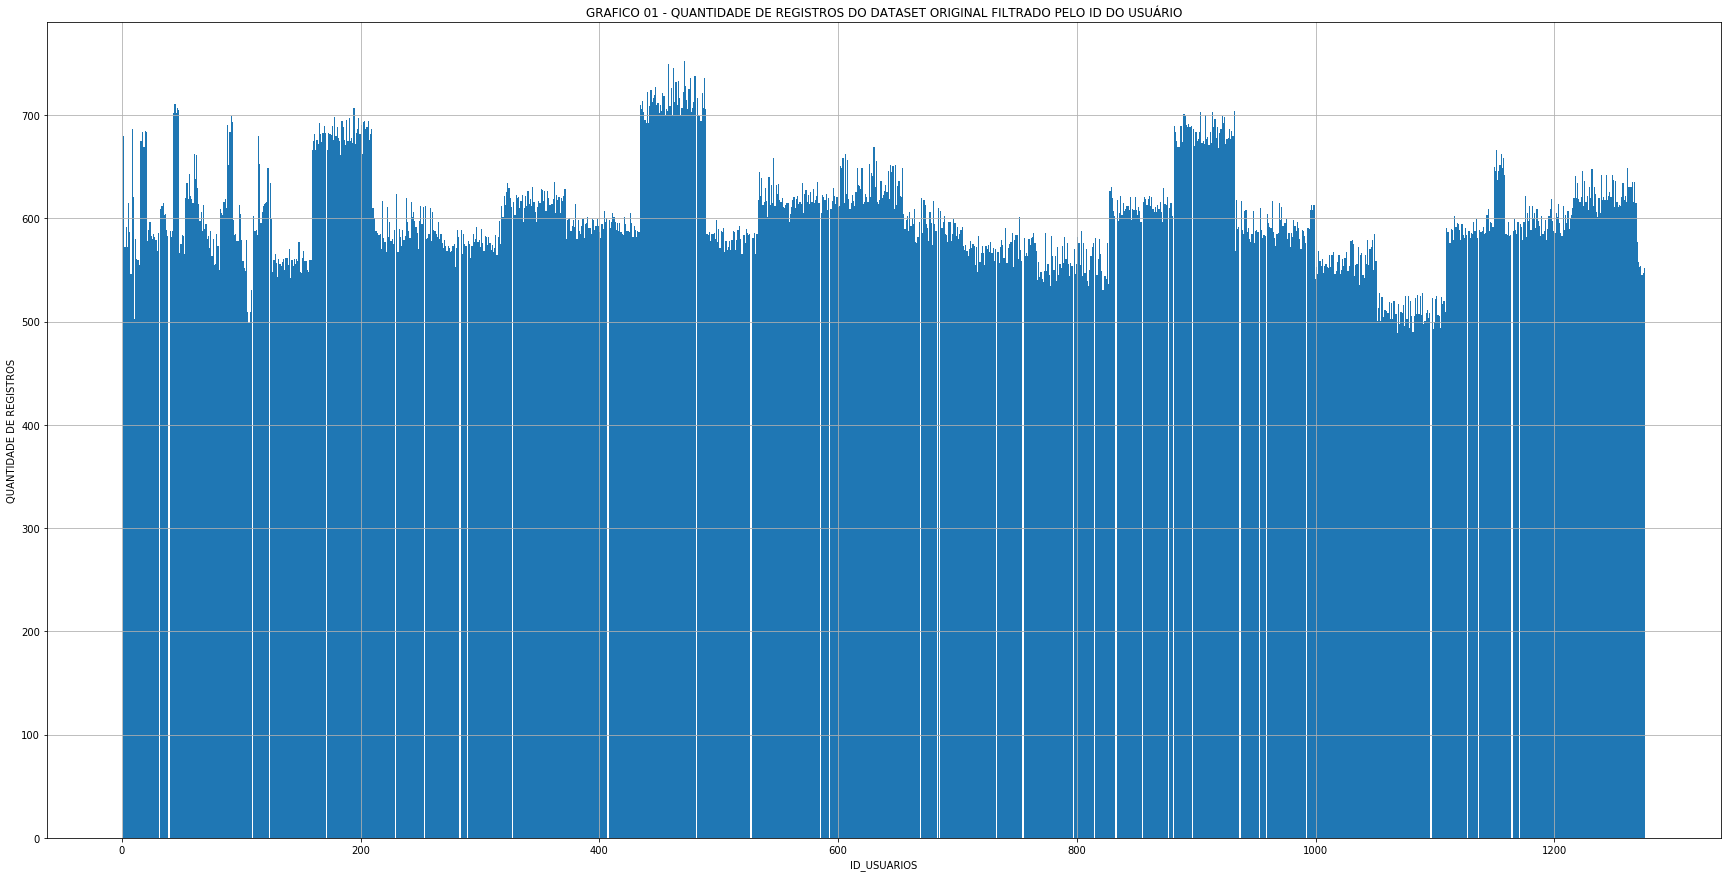

In [21]:
#Visualizando a quantidade de registros de acordo com o id_usuario.

# Analise gráfica

# Observa-se uma quantidade de 600 registros médios por ID de usuário.
# Pode-se inferir também pela visualização que existem IDs inexistentes
# no range de 1 a 1276 (ID máximo de usuário). As lacunas em branco indicam
# a posição de IDs que não apresentam nenhum registro.

plt.figure(figsize=(30,15))
graf_01 = df['id_usuario'].hist(bins=1276)
graf_01.set_ylabel("QUANTIDADE DE REGISTROS")
graf_01.set_xlabel("ID_USUARIOS")
graf_01.set_title("GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO")

# Análise do dataset principal

De acordo com o método describe executado no bloco acima, temos as seguintes informações:
    
    * 747.866 registros
    
    * Usuários:
        - ID mínimo: 1 
        - ID máximo: 1276
        
    * Mínimos e máximos das colunas de latitude e longitude apresentam sérias distorções  
    
    * Dos 747.866 registros, temos que estavam presentes no mesmo momento:
        
        - 037.365: responsável pelo registro estava sozinho
        - 710.501: responsável pelo registro + 1 pessoa
        - 561.109: responsável pelo registro + 2 pessoas
        - 485.927: responsável pelo registro + 3 pessoas
        - 413.437: responsável pelo registro + 4 pessoas
        - 342.098: responsável pelo registro + 5 pessoas
        - 274.410: responsável pelo registro + 6 pessoas
        - 201.630: responsável pelo registro + 7 pessoas
        - 132.960: responsável pelo registro + 8 pessoas
        - 065.053: responsável pelo registro + 9 pessoas
      
      Abaixo, estes números estão representados num gráfico:


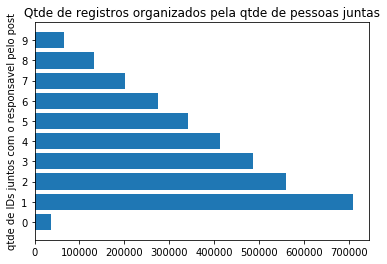

<Figure size 2160x1080 with 0 Axes>

In [22]:
nro_pessoas = {'usuarios': ['0','1','2','3','4','5','6','7','8','9'],
    'qtd': [37365,710501,561109,485927,413437,342098,274410,201630,132960,65053]}

df_nro_pessoas = pd.DataFrame(nro_pessoas,columns=['usuarios','qtd'])#, columns=['usuarios_juntos','quantidade'])
fig_00, ax_00 = plt.subplots()
ax_00.set_ylabel('qtde de IDs juntos com o responsavel pelo post')
ax_00.set_title('Qtde de registros organizados pela qtde de pessoas juntas')
ax_00.barh(df_nro_pessoas['usuarios'],df_nro_pessoas['qtd'])
fig_00 = plt.figure(figsize=(30,15))

# Observações sobre as coordenadas geográficas

Podemos notar que as informações de latitude e longitude estão
com registros de valores absolutos colossais da ordem de 10^19.
Consideraremos, a priori, tais regitros como inconsistentes.

A latitude poderá variar unicamente entre -90 graus (SUL) e +90 graus (NORTE).
Já a longitude varia entre -180 (OESTE) e +180(LESTE).

Valores que extrapolem este limites serão considerados inconsistentes. A instrução
abaixo seleciona estes dados e os armazena no DataFrame df_gps_invalido.


In [23]:
#Selecionando os pontos outliers
df_gps_ruido = pd.DataFrame(df[  (df['gps_lat']>3000) | (df['gps_lat']<-3000)  |  (df['gps_long']<-3000) | (df['gps_long']>3000) ] )

In [24]:
print("Quantidade de registros com ruídos nas coordenadas geográficas: ", df_gps_ruido.count()[0])

Quantidade de registros com ruídos nas coordenadas geográficas:  86521


In [25]:
#Exclusão dos registros do dataframe principal:
df = df.drop(df_gps_ruido.index)

In [26]:
#Apos a exclusão, o dataframe principal df ficou com 520.721 registros
df_gps_ruido[(df_gps_ruido['gps_lat']<-90)]

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
615373,799,-2.620060e+04,-9.491040e+04,0,0,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
159287,1257,-1.669870e+02,-1.988020e+04,37,45,83,111,125,0,0,0,0,2100-01-02 07:03:25,07:03:25
133737,1219,-1.232030e+03,1.147770e+05,121,0,0,0,0,0,0,0,0,2100-01-02 07:03:25,07:03:25
376911,439,-1.808260e+02,-1.661640e+04,81,111,121,127,128,131,137,165,203,2100-01-02 07:08:53,07:08:53
414055,487,-9.087190e+04,-2.327550e+04,0,0,0,0,0,0,0,0,0,2100-01-02 07:08:53,07:08:53
397602,465,-8.262060e+03,-4.508220e+03,0,0,0,0,0,0,0,0,0,2100-01-02 07:08:53,07:08:53
74659,1127,-4.030300e+05,5.944910e+06,0,0,0,0,0,0,0,0,0,2100-01-02 07:34:31,07:34:31
74068,1126,-2.951050e+04,-1.496580e+04,0,0,0,0,0,0,0,0,0,2100-01-02 07:34:31,07:34:31
72903,1124,-3.277740e+03,-1.778760e+03,727,951,0,0,0,0,0,0,0,2100-01-02 07:34:31,07:34:31
152436,1247,-1.170720e+05,-7.650360e+04,0,0,0,0,0,0,0,0,0,2100-01-02 08:33:04,08:33:04


In [27]:
df_gps_ruido[df_gps_ruido['id_usuario']==1260].describe()

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GRAFICO - registros excluídos do dataset por terem coordenadas impossíveis

Text(0.5,1,'GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO')

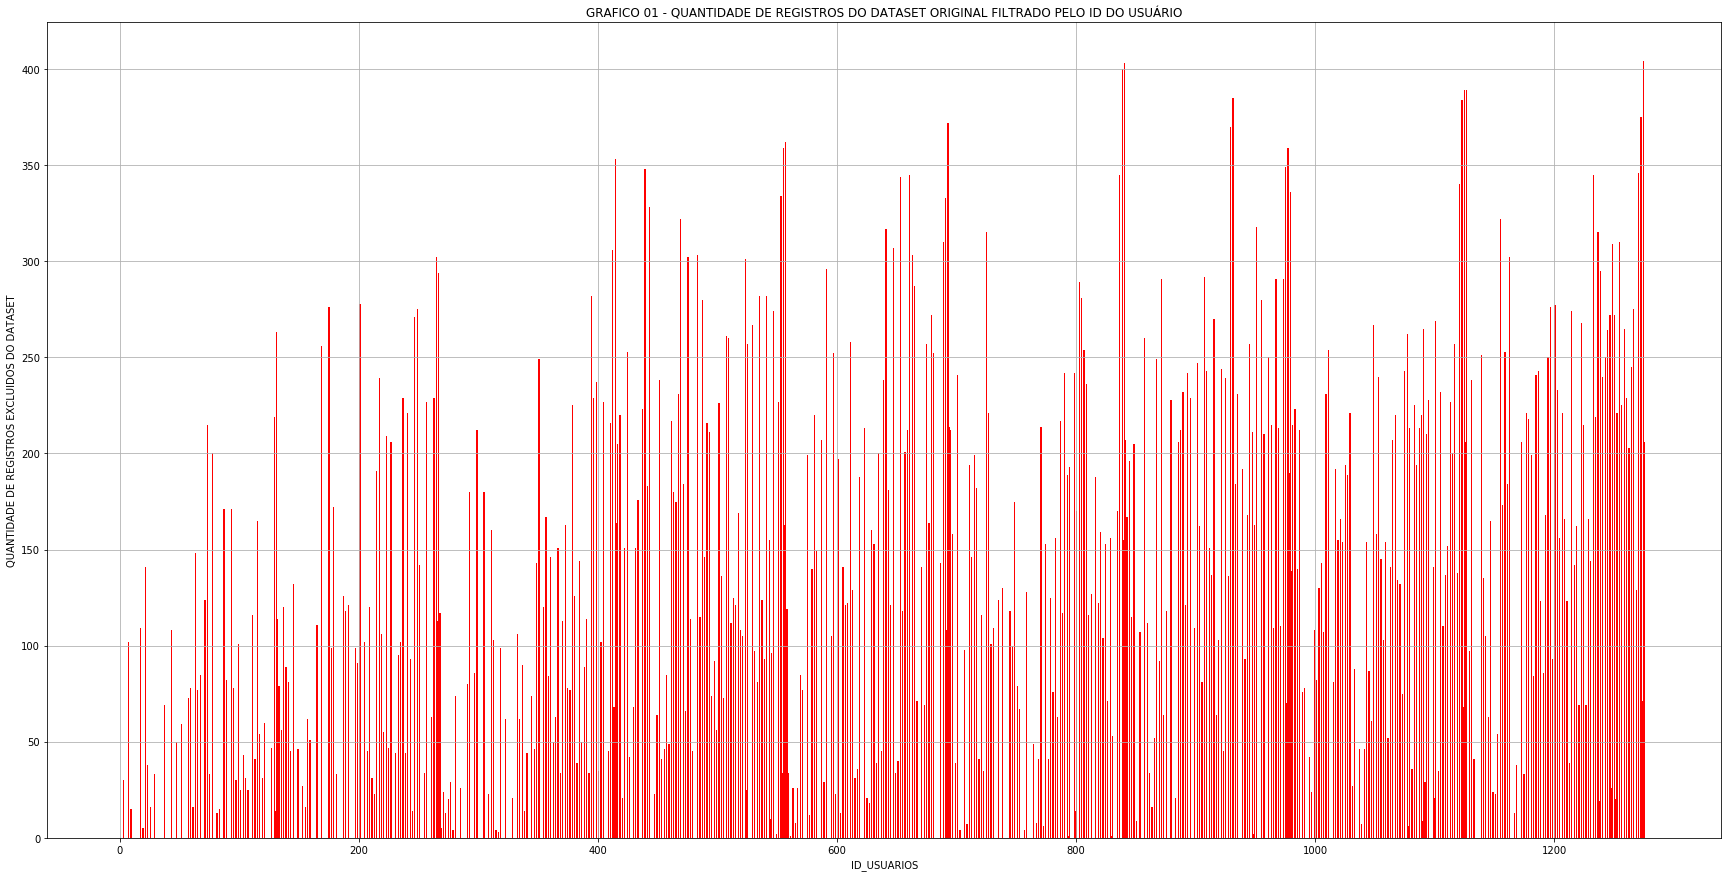

In [28]:
plt.figure(figsize=(30,15))
graf_001 = df_gps_ruido['id_usuario'].hist(bins=1276,color='red')
graf_001.set_ylabel("QUANTIDADE DE REGISTROS EXCLUIDOS DO DATASET")
graf_001.set_xlabel("ID_USUARIOS")
graf_001.set_title("GRAFICO 01 - QUANTIDADE DE REGISTROS DO DATASET ORIGINAL FILTRADO PELO ID DO USUÁRIO")

# Gráfico dos 520.721 registros com posições geográficas válidas

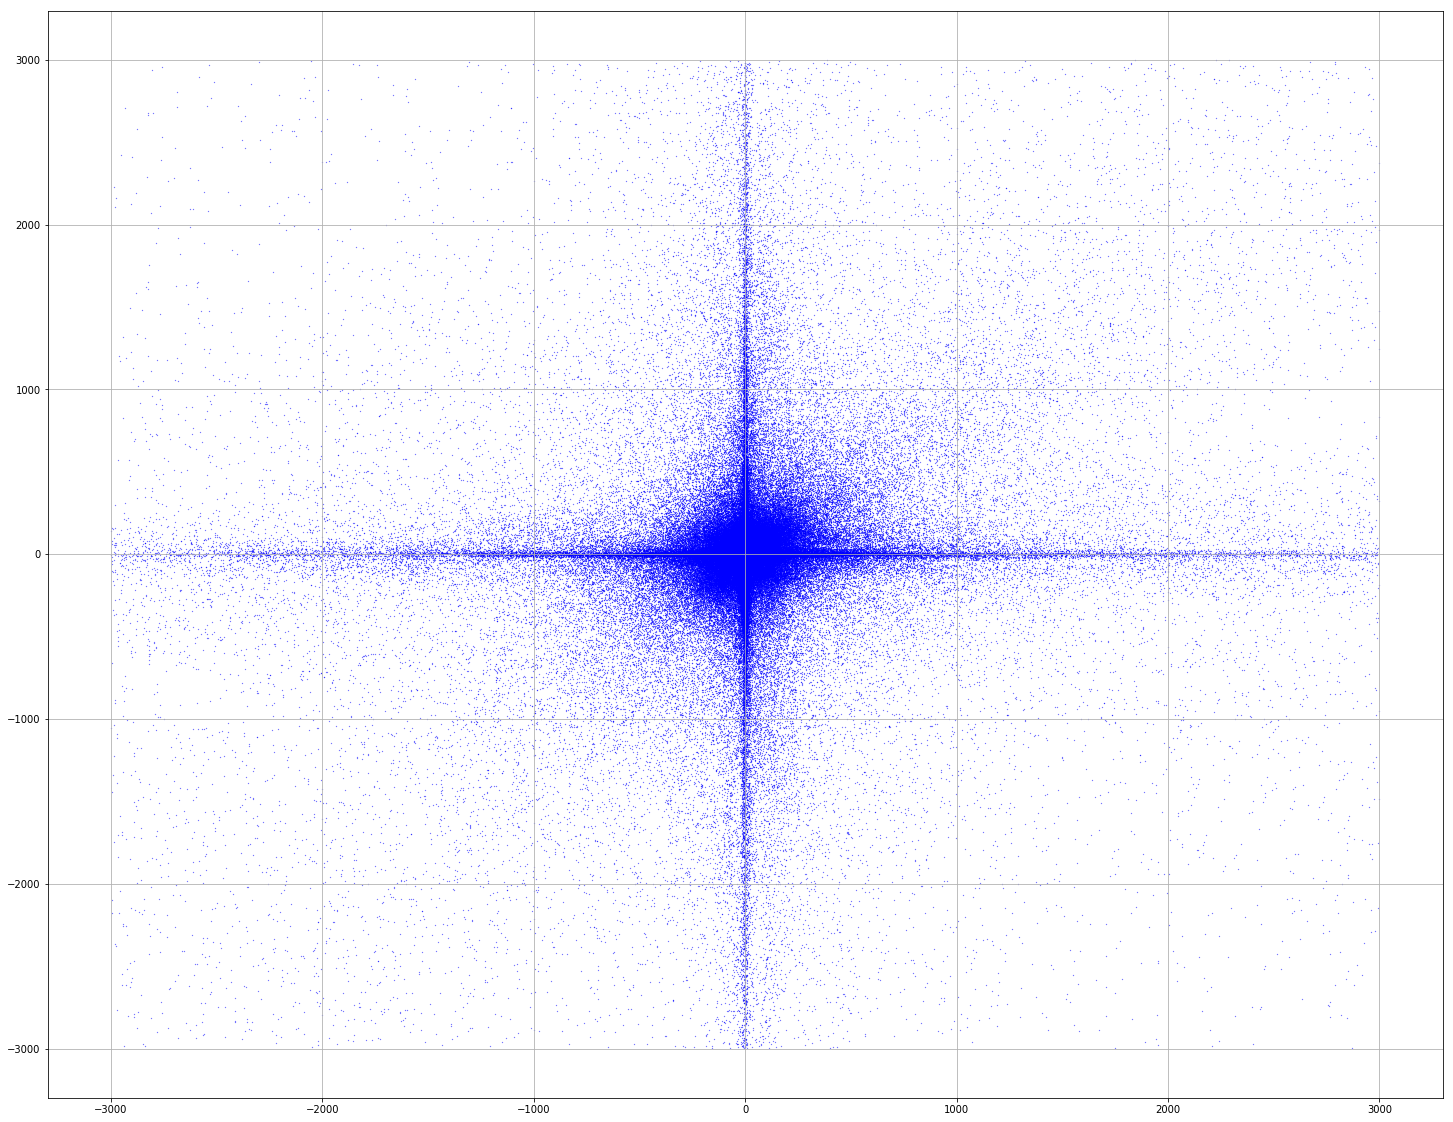

In [29]:
plt.figure(figsize=(25,20))
graf_02 = plt.scatter(df['gps_long'],df['gps_lat'],s=0.05,c='blue')
plt.grid(True)
#graf_02.set_ylabel("LONGITUDE")
#graf_02.set_xlabel("LATITUDE")
#graf_02.title("GRAFICO 02 - REPRESENTAÇÃO DO POSICIONAMENTO GEOGRÁFICO DOS USUÁRIOS EM CADA UM DOS 520.721 REGISTROS")

In [30]:
#df.groupby(['id_usuario'])['gps_lat'].count()

In [31]:
#df_qtd_registros_por_id = pd.DataFrame(df.groupby(['id_usuario'])['gps_lat'].count(), columns=['id_usuario','qtd_registros'])
#df_qtd_registros_por_id
#plt.scatter(df_qtd_registros_por_id['id_usuario'],df_qtd_registros_por_id['gps_lat'],s=0.1,c='red')

#plt.plot(df.groupby(['id_usuario'])['gps_lat'].count())
#df.groupby('id_usuario')

# GRÁFICO 02 - Quantidade de registros válidos de acordo com o ID do usuário

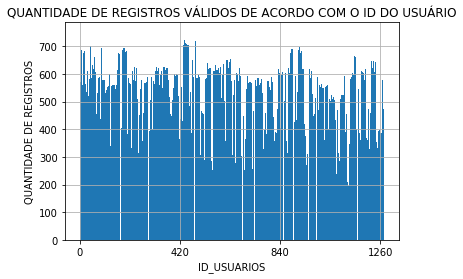

In [32]:
#Visualizando a quantidade de registros VÁLIDOS de acordo com o id_usuario.

fig_02, ax_02 = plt.subplots()
#fig_02 = plt.figure(figsize=(80,50))

ax_02 = df['id_usuario'].hist(bins=1276)
ax_02.grid(zorder=0)
ax_02.set_ylabel("QUANTIDADE DE REGISTROS")
ax_02.set_xlabel("ID_USUARIOS")
ax_02.set_title("QUANTIDADE DE REGISTROS VÁLIDOS DE ACORDO COM O ID DO USUÁRIO")
ax_02.set_xticks(np.arange(0,1278,420))
#ax_02.show()

#graf_02 = df['id_usuario'].hist(bins=1276)
#graf_02.grid(zorder=0)
#graf_02.set_ylabel("QUANTIDADE DE REGISTROS",fontsize=50)
#graf_02.set_xlabel("ID_USUARIOS",fontsize=50)
#graf_02.set_title("QUANTIDADE DE REGISTROS VÁLIDOS DE ACORDO COM O ID DO USUÁRIO",fontsize=60)
#graf_02.set_xticks(1276)

# GRÁFICO 03 - Quantidade de registros COM RUÍDO de acordo com o ID do usuário

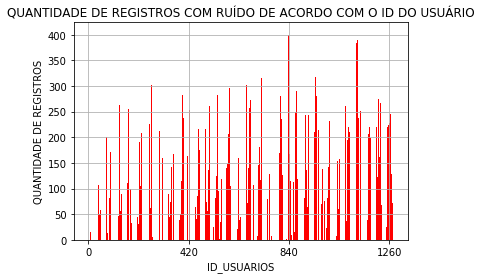

In [33]:
#plt.figure(figsize=(80,50))
fig_03, ax_03 = plt.subplots()
ax_03 = df_gps_ruido['id_usuario'].hist(bins=1276,color='red')
ax_03.set_ylabel("QUANTIDADE DE REGISTROS")
ax_03.set_xlabel("ID_USUARIOS")
ax_03.set_title("QUANTIDADE DE REGISTROS COM RUÍDO DE ACORDO COM O ID DO USUÁRIO")
ax_03.set_xticks(np.arange(0,1278,420))

In [34]:
df_gps_ruido.head()

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
597540,769,-4.05392,34450.90,3,4,5,6,7,8,9,10,11,2100-01-02 05:28:05,05:28:05
609760,789,31.37290,-3681.61,1,3,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
611455,791,18101.60000,-273253.00,0,0,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
615373,799,-26200.60000,-94910.40,0,0,0,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
613692,795,-3.56757,7054.47,1,3,4,5,6,7,8,0,0,2100-01-02 05:28:05,05:28:05


In [35]:
#df[(df['data']=='2100-01-03 01:20:38')  & (df['a']==3)]
df[(df['data']=='2100-01-02 05:28:05')  & (df['a']==5) & (df['b']==15)]
#df[(df['i']==813)]

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
624903,813,-16.7277,887.058,5,15,17,0,0,0,0,0,0,2100-01-02 05:28:05,05:28:05
627738,819,15.0207,132.388,5,15,17,19,21,0,0,0,0,2100-01-02 05:28:05,05:28:05


# GRAFICO - registros que precisam ter sua posição identificada

Text(0.5,1,'QUANTIDADE DE REGISTROS FALTANTES DE ACORDO COM O ID DO USUÁRIO')

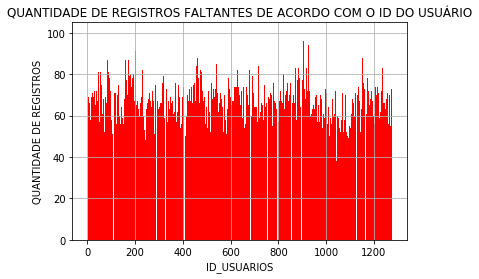

In [36]:
#Visualizando a quantidade de registros VÁLIDOS de acordo com o id_usuario.
#plt.figure(figsize=(200,60))
graf_04 = dataset_faltantes['id_usuario'].hist(bins=1276,color='red')
graf_04.set_ylabel("QUANTIDADE DE REGISTROS")
graf_04.set_xlabel("ID_USUARIOS")
graf_04.set_title("QUANTIDADE DE REGISTROS FALTANTES DE ACORDO COM O ID DO USUÁRIO")

# GRÁFICO 05 - Rota do id_usuário=794

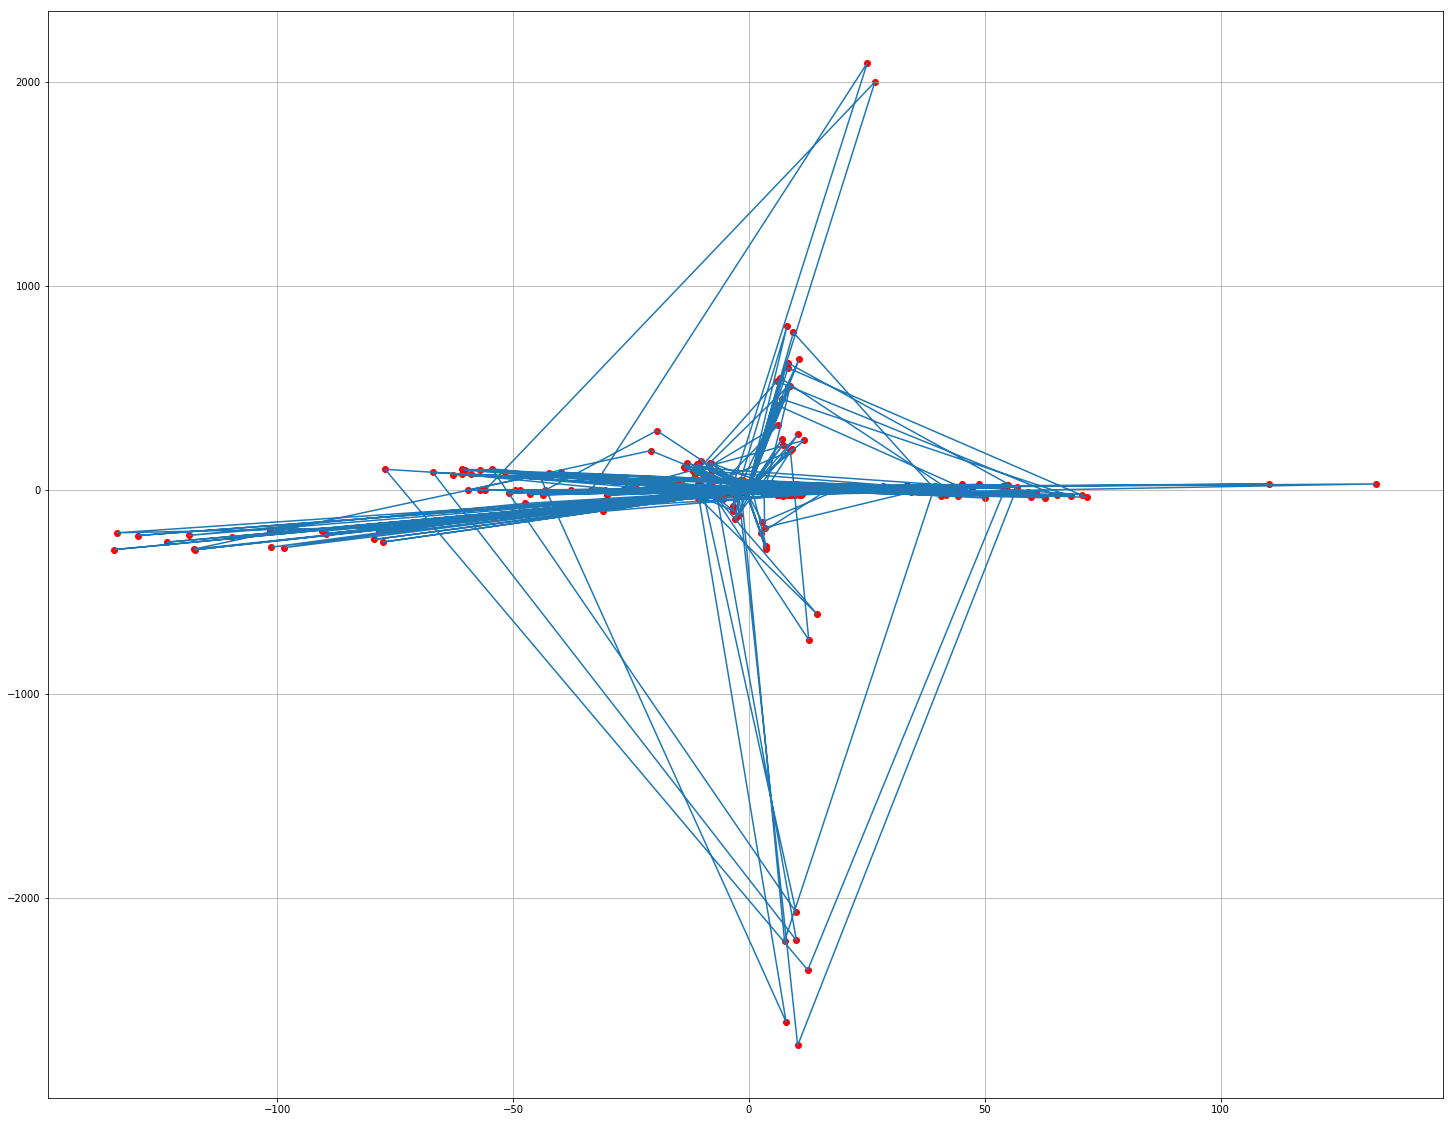

In [37]:
df_usuario = df[df['id_usuario']==794]
plt.figure(figsize=(25,20))
graf_05 = plt.plot(df_usuario['gps_long'],df_usuario['gps_lat'])
graf_05 = plt.scatter(df_usuario['gps_long'],df_usuario['gps_lat'],c='red')
plt.grid(True)

In [38]:
#df_2 = pd.DataFrame(columns = ['index_ruido','index_faltante'])
        
#for indice, linha in dataset_faltantes.iterrows():
#    df_2 = df_2.append(df_gps_ruido.loc[ (df_gps_ruido['data']==linha['data']) & (df_gps_ruido['id_usuario']==linha['id_usuario'])])

In [39]:
dataset_faltantes.head(5)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,NaN,NaN,2100-01-05 01:20:38,01:20:38
1,1000,NaN,NaN,2100-01-10 01:20:38,01:20:38
2,1000,NaN,NaN,2100-01-16 01:20:38,01:20:38
3,1000,NaN,NaN,2100-01-04 13:01:32,13:01:32
4,1000,NaN,NaN,2100-01-04 21:49:39,21:49:39


# GRÁFICO 06 - Registros faltantes distribuídos pelas 24h do dia

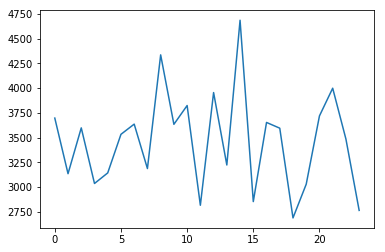

In [40]:
dataset_faltantes_horas = dataset_faltantes.set_index(pd.DatetimeIndex(dataset_faltantes['data']))
dataset_faltantes_horas = dataset_faltantes_horas.groupby(dataset_faltantes_horas.index.hour).count()['data']
plt.plot(dataset_faltantes_horas.index, dataset_faltantes_horas)

In [41]:
dataset_faltantes.head(30)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,NaN,NaN,2100-01-05 01:20:38,01:20:38
1,1000,NaN,NaN,2100-01-10 01:20:38,01:20:38
2,1000,NaN,NaN,2100-01-16 01:20:38,01:20:38
3,1000,NaN,NaN,2100-01-04 13:01:32,13:01:32
4,1000,NaN,NaN,2100-01-04 21:49:39,21:49:39
5,1000,NaN,NaN,2100-01-06 21:49:39,21:49:39
6,1000,NaN,NaN,2100-01-05 10:11:40,10:11:40
7,1000,NaN,NaN,2100-01-10 10:11:40,10:11:40
8,1000,NaN,NaN,2100-01-21 10:11:40,10:11:40
9,1000,NaN,NaN,2100-01-25 10:11:40,10:11:40


# ITERAR CADA UM DOS REGISTROS FALTANTES

In [42]:
df[(df['data']=='2100-01-06 16:06:30')]

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
188168,152,-0.276694,3.548080,1,0,0,0,0,0,0,0,0,2100-01-06 16:06:30,16:06:30
182585,143,69.413600,-7.976500,5,11,19,21,45,47,0,0,0,2100-01-06 16:06:30,16:06:30
174231,12,1.523270,-3.080050,1,2,3,4,5,6,7,0,0,2100-01-06 16:06:30,16:06:30
179798,139,-2.398660,1.720120,1,2,3,4,5,6,7,0,0,2100-01-06 16:06:30,16:06:30
180918,140,-0.249998,4.958790,1,2,3,4,5,6,0,0,0,2100-01-06 16:06:30,16:06:30
168662,1270,-19.146400,-20.687000,5,7,15,17,19,23,29,0,0,2100-01-06 16:06:30,16:06:30
180354,13,-21.166400,-1.353400,5,7,9,0,0,0,0,0,0,2100-01-06 16:06:30,16:06:30
179237,138,-2.194340,-2.706810,1,2,3,4,5,6,7,8,0,2100-01-06 16:06:30,16:06:30
183703,145,-0.939506,-152.511000,1,2,3,4,5,6,7,0,0,2100-01-06 16:06:30,16:06:30
177010,134,-0.517205,-0.326770,1,2,3,4,5,6,7,8,0,2100-01-06 16:06:30,16:06:30


In [43]:
dataset_faltantes.head(10000)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,NaN,NaN,2100-01-05 01:20:38,01:20:38
1,1000,NaN,NaN,2100-01-10 01:20:38,01:20:38
2,1000,NaN,NaN,2100-01-16 01:20:38,01:20:38
3,1000,NaN,NaN,2100-01-04 13:01:32,13:01:32
4,1000,NaN,NaN,2100-01-04 21:49:39,21:49:39
5,1000,NaN,NaN,2100-01-06 21:49:39,21:49:39
6,1000,NaN,NaN,2100-01-05 10:11:40,10:11:40
7,1000,NaN,NaN,2100-01-10 10:11:40,10:11:40
8,1000,NaN,NaN,2100-01-21 10:11:40,10:11:40
9,1000,NaN,NaN,2100-01-25 10:11:40,10:11:40


In [44]:
dataset_faltantes[dataset_faltantes.index==11]['gps_lat'].isna()

11    True
Name: gps_lat, dtype: bool

# O BLOCO ABAIXO TOMA UNS 20 MINUTOS DE EXECUCAO

In [45]:
if(FLAG_CARREGAR_FALTANTES_PREENCHIDOS==False):

    #ITERANDO CADA UM DOS REGISTROS FALTANTES
    i=-1
    for indice, registro_faltante in dataset_faltantes.iterrows():
        i=i+1
        if(i%1000==0): #para mostrar a evolucao da execucao do laco
            print(i)

        usuario_faltante = registro_faltante['id_usuario']
        data_faltante = registro_faltante['data']
        hora_faltante = registro_faltante['hora']


        #Selecionando TODOS os registros da data/hora em questao
        df_validos_do_horario = pd.DataFrame(df[(df['data']==data_faltante)])

        resposta = procura_id(usuario_faltante, df_validos_do_horario)

        if(resposta['encontrado']==True):
            #print("REGISTRO FALTANTE:\n ", dataset_faltantes[dataset_faltantes.index==indice])
            #print("INDICE", indice)
            #print("coordenadas: ", resposta['coordenadas'])
            #print("registro faltante: ", registro_faltante)

            #Atualiza coordenadas do dataset_faltantes
            dataset_faltantes.gps_lat.iloc[indice] = resposta['coordenadas'][0]
            dataset_faltantes.gps_long.iloc[indice] = resposta['coordenadas'][1]

            #print("DATASET VALIDO: \n")
            #print(df_validos_do_horario)

        #Selecionando TODOS os registros faltantes do mesmo usuarios
        #df_794_faltantes = dataset_faltantes[(dataset_faltantes['id_usuario']==794)]


0


/Users/pinguim/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1000
2000
Usuario  103  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-05 23:22:46
Usuario  103  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 09:52:11
Usuario  103  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-14 19:56:00
Usuario  103  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 10:56:25
Usuario  103  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-01 02:30:53
3000
4000
5000
Usuario  107  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-03 18:34:57
Usuario  107  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 21:32:30
Usuario  107  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 09:25:46
Usuario  107  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 12:24:24
6000
Usuario  10  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-05 07:43:38
Usuario  10  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-07 14:36:28
Usuario  10  esta em mais de um lugar

Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-30 08:59:19
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 08:59:19
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-12 08:59:19
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-13 08:59:19
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 04:46:45
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-03 10:00:11
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-05 10:00:11
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 01:04:35
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-08 01:04:35
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-29 08:07:25
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 13:05:01
Usuario  11  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-30 1

21000
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 14:45:58
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-28 14:45:58
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-11 06:36:41
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 06:36:41
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 21:49:09
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 21:49:09
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-26 21:49:09
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-05 01:49:44
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-08 01:49:44
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-09 03:23:38
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-11 03:23:38
Usuario  15  esta em mais de um lugar ao mesmo tempo. Horario:  2100-0

Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 15:31:46
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 00:08:15
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 14:45:34
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 14:45:34
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 15:04:45
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 15:04:45
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-04 01:03:09
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 20:11:51
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-30 18:54:18
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-26 13:59:37
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-28 13:59:37
Usuario  17  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-14 2

Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 00:08:15
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 00:08:15
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 03:25:46
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 14:45:34
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-25 15:04:45
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-25 01:03:09
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 21:08:29
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 21:08:29
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 20:11:51
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 15:24:00
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-01 22:40:00
Usuario  1  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 11:02:41
Usua

Usuario  21  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-29 20:20:07
Usuario  21  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-06 20:20:07
Usuario  21  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-12 20:20:07
Usuario  21  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 21:19:31
Usuario  21  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-06 21:19:31
27000
Usuario  230  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 05:00:59
Usuario  230  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 05:00:59
Usuario  238  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 05:00:59
Usuario  239  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-06 21:19:31
Usuario  23  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-06 17:09:57
Usuario  23  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-08 17:09:57
Usuario  23  esta em mais de um lugar ao mesmo tempo. Horario:  21

Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-10 14:10:24
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-12 14:10:24
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 17:25:36
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-13 09:54:21
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-08 11:04:13
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-08 19:30:01
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-13 19:30:01
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-14 13:38:33
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 13:38:33
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-11 17:58:11
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 12:30:11
Usuario  2  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 12:30:11
Usua

Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-13 09:30:52
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-30 14:57:02
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-01 12:54:33
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-01 06:33:49
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 06:33:49
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-04 06:33:49
Usuario  33  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-05 12:24:57
35000
Usuario  351  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 13:04:22
36000
Usuario  359  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-25 22:50:30
Usuario  35  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-11 14:50:05
Usuario  35  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-07 14:27:54
Usuario  35  esta em mais de um lugar ao mesmo tempo. Horario:

Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-30 21:50:56
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-13 00:21:45
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 00:21:45
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-26 00:21:45
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 20:25:44
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 07:06:28
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 07:06:28
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 09:54:24
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 20:30:41
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-07 09:36:13
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-19 12:43:37
Usuario  3  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 10:39:31
Usua

Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 14:40:56
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 10:42:31
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 13:01:30
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 04:49:29
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 04:49:29
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-04 04:49:29
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-06 04:49:29
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 09:15:04
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 16:18:44
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-26 16:18:44
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-25 05:10:54
Usuario  45  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-03 0

Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 22:26:37
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-06 22:26:37
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-28 14:53:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 14:53:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-13 14:53:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-18 14:53:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-29 04:44:48
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-29 10:34:49
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-04 10:34:49
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-08 03:05:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-10 03:05:01
Usuario  4  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-13 03:05:01
Usua

Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 01:31:24
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-14 23:14:36
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 11:50:55
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-26 11:50:55
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-28 04:37:07
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-19 15:46:42
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 15:46:42
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 15:46:42
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 23:21:30
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 23:21:30
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 21:50:19
Usuario  5  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-22 21:50:19
Usua

Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-07 16:47:09
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-09 16:47:09
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 08:03:31
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 08:03:31
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-10 01:06:58
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 01:06:58
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-12 16:14:18
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 16:14:18
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-13 07:07:59
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 20:27:04
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 20:27:04
Usuario  6  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-11 15:15:18
Usua

Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-23 15:53:12
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 07:07:34
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 07:07:34
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-19 07:07:34
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-18 16:20:17
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-17 10:01:39
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 10:01:39
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 05:31:31
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 05:31:31
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 10:47:02
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 07:13:30
Usuario  7  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 00:01:31
Usua

Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-02-02 04:21:37
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 04:48:53
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-21 19:07:21
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-14 22:38:44
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-16 22:38:44
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-19 22:38:44
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 22:38:44
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-20 05:46:48
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-27 05:46:48
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-15 06:11:34
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-24 18:46:50
Usuario  8  esta em mais de um lugar ao mesmo tempo. Horario:  2100-01-19 09:58:14
Usua

In [46]:
if(FLAG_CARREGAR_FALTANTES_PREENCHIDOS==False):
#df[(df['id_usuario']==1000) ]
#df[datetime.time(df['hora']) == "05:28:05" ]
#dataset_faltantes.gps_lat.iloc[1347]=4
#raw_data = {'Path': lista_cidades_int}
    dataset_faltantes.to_csv('faltantes_preenchidos_20181209_1000.csv', index=False)
#type(df['hora'])
#dataset_faltantes.info()
#df.loc[df['data'].between_time('14:00','14:40')]
#df
#dataset_faltantes

In [47]:
#usuarios que estao em mais de um lugar ao mesmo tempo:
# 10 - uns 20 registros. Ex de horarios:  2100-01-05 07:43:38 (3), 2100-01-18 09:25:46(4)
# 11 - uma cacetada. 2100-02-02 15:43:55 (13!), 2100-02-18 21:46:12 (10)
# 12 - 3 registros. 2100-01-29 21:50:17 (2),2100-02-04 04:12:20 (2), 2100-01-30 02:28:05 (2)
# 13 
# 15
# 17
# 194
# 19
# 1 - dezenas de registros do faltantes. Aqui 2100-01-19 03:23:38 tem 40 presencas!
# 218 - 
# 21
# 230
# 238
# 23
# 25
# 27
# 29
# 2
# 33
# 37
# 398
# 3
# 41
# 43
# 47
# 4
# 51
# 53
# 55
# 59
# 5 - 29 lugares as 2100-01-29 20:20:27
# 61
# 63
# 644
# 65
# 67
# 69
# 6
# 77
# 79
# 7 - 16 lugares 2100-01-21 10:01:39
# 81
# 83 - 3 lugares 2100-01-12 22:54:04
# 8 - 2100-01-28 19:08:29 em 12 lugares
# 92 - 
# 95 -







In [48]:
df[df.index==28790]

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
28790,1047,73.743,73.8121,25,45,47,91,95,101,103,105,0,2100-01-31 12:42:29,12:42:29


In [49]:
dataset_faltantes_file = pd.read_csv('faltantes_preenchidos_20181208.csv', sep=",", names=['id_usuario','gps_lat','gps_long','data','hora'])

# APLICANDO K-MEANS

In [50]:
pinguim = 0 
#Análise de registro por registro do dataset de registros faltantes
for indice,registro in dataset_faltantes.iterrows():
    pinguim=pinguim+1
    if(pinguim%100==0):
        print("Avaliados: ", pinguim)
        
    #A posicao geografica do registro já poderá ter sido
    #atualizada em virtude de algum registro anterior com o mesmo horário.
    #Como o update é realizada para todos os registros do horário Y de um 
    #usuário, então existe a possibilidade. Enfim, se a coordenada geográfica
    #já estiver definida, então podemos pular o registro e continuar a iteração.
    if(math.isnan(registro['gps_lat']) == False):
        #print("Valor preenchido encontrado!")
        continue
    

    #Seleciona TODOS os registros validos do usuario
    df_usuario_reg_validos = df[(df['id_usuario']==registro['id_usuario']) ]
    
    
   
    df_usuario_reg_validos = df_usuario_reg_validos.set_index(pd.DatetimeIndex(df_usuario_reg_validos['data']))
    #print(df_usuario_reg_validos)

    #Selecionando todos os registros faltantes do usuario
    df_usuario_reg_faltantes = dataset_faltantes[(dataset_faltantes['id_usuario']==registro['id_usuario'])]
    #print("Quantidade de registros validos para o usuario: ", df_usuario_reg_validos.count()[0])
    #print("Quantidade de registros faltantes para o usuario: ", df_usuario_reg_faltantes.count()[0])
        
    #Selecionando os registros faltantes do mesmo horario
    df_usuario_reg_horario = df_usuario_reg_validos.loc[df_usuario_reg_validos['data'].between_time(registro['hora'],registro['hora'])]
    
    #Separando as coordenadas num arquivo separado
    X = df_usuario_reg_horario.iloc[:, [1,2]].values
    #print(X.size)
    
    #Podem existir horários de registros faltantes do usuário X que não serão
    #encontrados nos registros váidos. Assim, teremos que seguir em frente e 
    #pesquisar um outro método para prever a posição. Se isso acontecer, então,
    #desconsidere o registro faltante e siga em frente na iteração.
    if(X.size==0):
        print("Horário inexistente:", registro['id_usuario'], ":", registro['data'])
        continue
    
    kmeans = KMeans(n_clusters = 1, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    y_means = kmeans.fit_predict(X)
    
    #Plotando posicoes encontradas deste horário
    ###graf = plt.scatter(df_usuario_reg_validos['gps_long'],df_usuario_reg_validos['gps_lat'])
    ###graf = plt.scatter(df_usuario_reg_horario['gps_long'],df_usuario_reg_horario['gps_lat'],s=40,c='red')
    
    #De acordo com a posicao planetaria, a longitude equivale ao eixo cartesiano horizontal e a latitude a vertical.
    #eixo X - longitude
    #eixo Y - latitude
    #Por isso invertemos abaixo. Primeiro o [:,1], depois o [:,0]
    ###graf = plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0],s=300, c='yellow')
    ###plt.grid(True)
    ###plt.show()
    
    ###print("Quantidade de registros validos: ", df_usuario_reg_horario.count()[0])
    #Atualizando coordenada faltante!!!
    #dataset_faltantes.gps_lat.iloc[indice]  = kmeans.cluster_centers_[:,0]
    #dataset_faltantes.gps_long.iloc[indice] = kmeans.cluster_centers_[:,1]
    
    dataset_faltantes.loc[(dataset_faltantes['id_usuario']==registro['id_usuario']) & (dataset_faltantes['hora']==registro['hora']) , 'gps_lat'] = kmeans.cluster_centers_[:,0]
    dataset_faltantes.loc[(dataset_faltantes['id_usuario']==registro['id_usuario']) & (dataset_faltantes['hora']==registro['hora']) , 'gps_long'] = kmeans.cluster_centers_[:,1]
    
    


Horário inexistente: 1001 : 2100-01-08 13:01:32
Horário inexistente: 1001 : 2100-01-14 04:25:13
Horário inexistente: 1001 : 2100-01-11 14:51:56
Avaliados:  100
Horário inexistente: 1001 : 2100-01-23 10:56:25
Horário inexistente: 1001 : 2100-01-29 10:56:25
Horário inexistente: 1001 : 2100-01-31 10:56:25
Avaliados:  200
Horário inexistente: 1003 : 2100-01-07 13:41:35
Horário inexistente: 1003 : 2100-01-09 13:41:35
Horário inexistente: 1003 : 2100-01-15 13:41:35
Horário inexistente: 1003 : 2100-01-24 16:50:18
Horário inexistente: 1003 : 2100-02-01 16:50:18
Horário inexistente: 1003 : 2100-02-03 07:06:17
Avaliados:  300
Horário inexistente: 1005 : 2100-01-03 01:20:38
Horário inexistente: 1005 : 2100-01-07 01:20:38
Horário inexistente: 1005 : 2100-01-05 10:16:39
Horário inexistente: 1005 : 2100-01-22 10:11:40
Horário inexistente: 1005 : 2100-01-30 10:11:40
Horário inexistente: 1005 : 2100-01-07 01:50:33
Horário inexistente: 1005 : 2100-01-28 10:56:25
Horário inexistente: 1005 : 2100-01-21 0

Horário inexistente: 1025 : 2100-01-20 03:40:04
Horário inexistente: 1027 : 2100-01-18 07:24:46
Horário inexistente: 1027 : 2100-01-17 14:51:56
Horário inexistente: 1027 : 2100-01-12 09:29:54
Horário inexistente: 1027 : 2100-01-13 09:29:54
Horário inexistente: 1027 : 2100-01-18 09:29:54
Horário inexistente: 1027 : 2100-01-20 09:29:54
Avaliados:  1800
Horário inexistente: 1027 : 2100-01-29 09:29:54
Horário inexistente: 1027 : 2100-01-31 09:29:54
Horário inexistente: 1027 : 2100-01-24 20:42:51
Horário inexistente: 1027 : 2100-01-26 16:15:39
Horário inexistente: 1027 : 2100-01-29 16:15:39
Horário inexistente: 1027 : 2100-01-30 16:15:39
Horário inexistente: 1027 : 2100-01-20 22:31:46
Horário inexistente: 1027 : 2100-01-21 22:31:46
Horário inexistente: 1027 : 2100-01-23 08:52:21
Horário inexistente: 1027 : 2100-01-25 08:52:21
Horário inexistente: 1027 : 2100-02-02 14:15:47
Horário inexistente: 1027 : 2100-01-30 11:50:16
Horário inexistente: 1027 : 2100-02-13 11:50:16
Horário inexistente: 10

Horário inexistente: 1055 : 2100-01-14 10:05:43
Horário inexistente: 1055 : 2100-01-16 14:27:38
Horário inexistente: 1055 : 2100-01-28 14:27:38
Horário inexistente: 1055 : 2100-01-29 14:27:38
Horário inexistente: 1055 : 2100-01-19 13:26:51
Horário inexistente: 1055 : 2100-01-19 14:19:25
Horário inexistente: 1055 : 2100-01-18 22:43:38
Horário inexistente: 1055 : 2100-01-20 22:43:38
Horário inexistente: 1055 : 2100-01-25 22:43:38
Horário inexistente: 1055 : 2100-01-18 04:10:28
Horário inexistente: 1055 : 2100-01-20 20:24:30
Horário inexistente: 1055 : 2100-02-03 09:14:44
Horário inexistente: 1055 : 2100-02-05 09:14:44
Horário inexistente: 1055 : 2100-01-26 16:32:37
Horário inexistente: 1055 : 2100-02-01 16:32:37
Horário inexistente: 1055 : 2100-02-11 16:32:37
Avaliados:  3800
Horário inexistente: 1057 : 2100-01-19 14:19:25
Horário inexistente: 1057 : 2100-01-17 12:36:29
Horário inexistente: 1057 : 2100-01-25 13:54:37
Horário inexistente: 1057 : 2100-01-20 07:56:55
Horário inexistente: 10

Avaliados:  5000
Horário inexistente: 1075 : 2100-01-22 21:32:30
Horário inexistente: 1075 : 2100-01-15 00:27:27
Horário inexistente: 1075 : 2100-01-20 00:27:27
Horário inexistente: 1075 : 2100-01-23 00:27:27
Horário inexistente: 1075 : 2100-01-26 00:27:27
Horário inexistente: 1075 : 2100-01-20 14:12:17
Horário inexistente: 1075 : 2100-01-17 09:25:46
Horário inexistente: 1075 : 2100-01-22 09:25:46
Horário inexistente: 1075 : 2100-01-17 17:15:29
Horário inexistente: 1075 : 2100-01-17 12:00:05
Horário inexistente: 1075 : 2100-01-15 13:26:51
Horário inexistente: 1075 : 2100-01-16 13:26:51
Horário inexistente: 1075 : 2100-01-23 13:26:51
Horário inexistente: 1075 : 2100-01-27 22:43:38
Horário inexistente: 1075 : 2100-01-28 22:43:38
Horário inexistente: 1075 : 2100-01-25 16:02:07
Horário inexistente: 1075 : 2100-01-27 07:26:07
Horário inexistente: 1075 : 2100-02-01 07:26:07
Horário inexistente: 1075 : 2100-02-02 07:26:07
Horário inexistente: 1075 : 2100-01-28 10:22:23
Horário inexistente: 10

Avaliados:  5900
Horário inexistente: 1091 : 2100-01-07 15:38:48
Horário inexistente: 1091 : 2100-01-10 18:34:57
Horário inexistente: 1091 : 2100-01-12 18:34:57
Horário inexistente: 1091 : 2100-01-11 07:43:38
Horário inexistente: 1091 : 2100-01-10 14:36:28
Horário inexistente: 1091 : 2100-01-14 14:36:28
Horário inexistente: 1091 : 2100-01-06 20:41:09
Horário inexistente: 1091 : 2100-01-08 20:41:09
Horário inexistente: 1091 : 2100-01-11 20:41:09
Horário inexistente: 1091 : 2100-01-16 20:41:09
Horário inexistente: 1091 : 2100-01-17 20:41:09
Horário inexistente: 1091 : 2100-01-07 22:52:02
Horário inexistente: 1091 : 2100-01-09 13:57:08
Horário inexistente: 1091 : 2100-01-07 12:20:53
Avaliados:  6000
Horário inexistente: 1091 : 2100-01-26 21:32:30
Horário inexistente: 1091 : 2100-01-21 14:12:17
Horário inexistente: 1091 : 2100-01-16 09:25:46
Horário inexistente: 1091 : 2100-01-20 09:25:46
Horário inexistente: 1091 : 2100-01-14 17:15:29
Horário inexistente: 1091 : 2100-01-21 17:15:29
Horári

Horário inexistente: 1105 : 2100-01-19 00:01:07
Horário inexistente: 1105 : 2100-01-20 00:01:07
Horário inexistente: 1105 : 2100-01-21 00:01:07
Horário inexistente: 1105 : 2100-01-20 15:43:49
Horário inexistente: 1105 : 2100-01-22 15:43:49
Horário inexistente: 1105 : 2100-01-24 15:43:49
Horário inexistente: 1105 : 2100-01-30 15:43:49
Horário inexistente: 1105 : 2100-01-31 07:26:07
Horário inexistente: 1105 : 2100-02-01 16:32:37
Horário inexistente: 1105 : 2100-01-26 18:48:04
Horário inexistente: 1105 : 2100-01-27 18:48:04
Horário inexistente: 1105 : 2100-01-28 18:48:04
Horário inexistente: 1105 : 2100-01-29 00:08:22
Horário inexistente: 1105 : 2100-01-30 10:22:23
Horário inexistente: 1107 : 2100-01-05 18:34:57
Horário inexistente: 1107 : 2100-01-06 18:34:57
Horário inexistente: 1107 : 2100-01-09 14:36:28
Horário inexistente: 1107 : 2100-01-11 14:36:28
Avaliados:  6900
Horário inexistente: 1107 : 2100-01-22 21:32:30
Horário inexistente: 1107 : 2100-01-28 21:32:30
Horário inexistente: 11

Horário inexistente: 1121 : 2100-01-29 09:14:27
Horário inexistente: 1121 : 2100-02-01 09:14:27
Horário inexistente: 1121 : 2100-02-02 09:14:27
Horário inexistente: 1121 : 2100-01-31 02:42:49
Horário inexistente: 1121 : 2100-02-04 02:42:49
Horário inexistente: 1121 : 2100-01-31 01:17:56
Horário inexistente: 1121 : 2100-02-02 01:17:56
Horário inexistente: 1121 : 2100-02-05 22:51:41
Avaliados:  8000
Horário inexistente: 1122 : 2100-01-26 11:50:24
Horário inexistente: 1122 : 2100-01-27 11:50:24
Horário inexistente: 1122 : 2100-01-28 11:50:24
Horário inexistente: 1123 : 2100-01-04 07:34:31
Horário inexistente: 1123 : 2100-01-08 18:55:01
Horário inexistente: 1123 : 2100-01-09 04:16:43
Horário inexistente: 1123 : 2100-01-16 21:49:57
Horário inexistente: 1123 : 2100-01-07 16:30:03
Horário inexistente: 1123 : 2100-01-08 21:03:55
Horário inexistente: 1123 : 2100-01-11 21:03:55
Horário inexistente: 1123 : 2100-01-16 08:41:52
Horário inexistente: 1123 : 2100-01-13 10:30:02
Horário inexistente: 11

Horário inexistente: 1127 : 2100-02-05 01:17:56
Horário inexistente: 1127 : 2100-02-01 22:51:41
Horário inexistente: 1129 : 2100-01-08 04:16:43
Horário inexistente: 1129 : 2100-01-17 18:35:08
Horário inexistente: 1129 : 2100-01-20 18:35:08
Horário inexistente: 1129 : 2100-01-13 10:30:02
Horário inexistente: 1129 : 2100-01-16 10:30:02
Horário inexistente: 1129 : 2100-01-20 10:30:02
Horário inexistente: 1129 : 2100-01-21 10:30:02
Horário inexistente: 1129 : 2100-01-22 10:30:02
Horário inexistente: 1129 : 2100-01-20 15:47:57
Horário inexistente: 1129 : 2100-01-29 09:14:27
Horário inexistente: 1129 : 2100-01-31 09:14:27
Horário inexistente: 1129 : 2100-02-05 09:14:27
Horário inexistente: 1129 : 2100-02-08 09:14:27
Horário inexistente: 1129 : 2100-02-09 09:14:27
Horário inexistente: 1129 : 2100-02-11 09:14:27
Avaliados:  8500
Avaliados:  8600
Horário inexistente: 1131 : 2100-01-02 07:34:31
Horário inexistente: 1131 : 2100-01-05 18:55:01
Horário inexistente: 1131 : 2100-01-08 18:55:01
Horári

Horário inexistente: 1155 : 2100-02-08 14:02:19
Horário inexistente: 1155 : 2100-02-11 14:02:19
Horário inexistente: 1155 : 2100-01-24 22:08:57
Horário inexistente: 1155 : 2100-01-21 11:42:39
Horário inexistente: 1155 : 2100-01-31 11:42:39
Horário inexistente: 1155 : 2100-02-05 11:42:39
Horário inexistente: 1155 : 2100-01-28 17:56:23
Horário inexistente: 1155 : 2100-01-27 13:14:03
Avaliados:  10400
Horário inexistente: 1156 : 2100-01-17 06:13:12
Horário inexistente: 1157 : 2100-01-02 10:27:33
Horário inexistente: 1157 : 2100-01-06 10:27:33
Horário inexistente: 1157 : 2100-01-02 22:16:21
Horário inexistente: 1157 : 2100-01-05 22:16:21
Horário inexistente: 1157 : 2100-01-07 22:16:21
Horário inexistente: 1157 : 2100-01-09 05:22:46
Horário inexistente: 1157 : 2100-01-07 19:16:36
Horário inexistente: 1157 : 2100-01-06 08:28:13
Horário inexistente: 1157 : 2100-01-07 08:28:13
Horário inexistente: 1157 : 2100-01-05 10:21:02
Horário inexistente: 1157 : 2100-01-07 10:21:02
Horário inexistente: 1

Horário inexistente: 1173 : 2100-01-24 11:20:40
Horário inexistente: 1173 : 2100-02-01 11:20:40
Horário inexistente: 1173 : 2100-01-27 08:59:19
Horário inexistente: 1173 : 2100-02-13 08:59:19
Avaliados:  11600
Avaliados:  11700
Horário inexistente: 1175 : 2100-01-27 03:40:41
Horário inexistente: 1175 : 2100-01-29 03:40:41
Horário inexistente: 1175 : 2100-01-30 21:40:35
Horário inexistente: 1175 : 2100-02-04 21:40:35
Horário inexistente: 1175 : 2100-02-07 21:40:35
Horário inexistente: 1175 : 2100-02-08 21:40:35
Avaliados:  11800
Horário inexistente: 1177 : 2100-01-09 21:33:08
Horário inexistente: 1177 : 2100-01-04 07:31:31
Horário inexistente: 1177 : 2100-01-05 22:15:34
Horário inexistente: 1177 : 2100-01-06 00:17:50
Horário inexistente: 1177 : 2100-01-07 00:17:50
Horário inexistente: 1177 : 2100-01-13 00:17:50
Horário inexistente: 1177 : 2100-01-14 00:17:50
Horário inexistente: 1177 : 2100-01-13 20:58:05
Horário inexistente: 1177 : 2100-01-24 18:00:38
Horário inexistente: 1177 : 2100-0

Horário inexistente: 1193 : 2100-02-04 11:41:19
Horário inexistente: 1195 : 2100-01-04 02:09:34
Horário inexistente: 1195 : 2100-01-07 02:09:34
Horário inexistente: 1195 : 2100-01-04 22:15:34
Horário inexistente: 1195 : 2100-01-10 22:15:34
Horário inexistente: 1195 : 2100-01-11 13:10:16
Horário inexistente: 1195 : 2100-01-14 13:10:16
Horário inexistente: 1195 : 2100-01-08 22:38:50
Horário inexistente: 1195 : 2100-01-09 22:38:50
Horário inexistente: 1195 : 2100-01-23 20:58:05
Horário inexistente: 1195 : 2100-01-24 08:02:10
Horário inexistente: 1195 : 2100-01-09 12:42:00
Avaliados:  13200
Horário inexistente: 1195 : 2100-01-14 12:42:00
Horário inexistente: 1195 : 2100-01-16 12:42:00
Horário inexistente: 1195 : 2100-01-21 12:42:00
Horário inexistente: 1195 : 2100-01-15 08:00:24
Horário inexistente: 1195 : 2100-01-20 08:00:24
Horário inexistente: 1195 : 2100-01-21 12:44:39
Horário inexistente: 1195 : 2100-01-24 12:44:39
Horário inexistente: 1195 : 2100-01-12 08:36:39
Horário inexistente: 1

Avaliados:  14300
Horário inexistente: 1209 : 2100-02-01 15:43:55
Horário inexistente: 1209 : 2100-02-02 15:43:55
Horário inexistente: 1209 : 2100-01-31 21:40:35
Avaliados:  14400
Horário inexistente: 1211 : 2100-01-09 21:33:08
Horário inexistente: 1211 : 2100-01-07 07:31:31
Horário inexistente: 1211 : 2100-01-09 00:17:50
Horário inexistente: 1211 : 2100-01-10 08:02:10
Horário inexistente: 1211 : 2100-01-22 08:02:10
Horário inexistente: 1211 : 2100-01-23 08:02:10
Horário inexistente: 1211 : 2100-01-24 08:02:10
Horário inexistente: 1211 : 2100-01-13 03:51:11
Horário inexistente: 1211 : 2100-01-20 06:13:57
Avaliados:  14500
Horário inexistente: 1212 : 2100-01-22 02:21:56
Horário inexistente: 1213 : 2100-01-16 22:46:31
Horário inexistente: 1213 : 2100-01-23 07:20:16
Horário inexistente: 1213 : 2100-01-30 07:20:16
Horário inexistente: 1213 : 2100-01-31 07:20:16
Avaliados:  14600
Horário inexistente: 1215 : 2100-01-08 21:33:08
Horário inexistente: 1215 : 2100-01-22 02:09:57
Avaliados:  1470

Avaliados:  16000
Horário inexistente: 1233 : 2100-01-05 10:52:17
Horário inexistente: 1233 : 2100-01-07 10:52:17
Horário inexistente: 1233 : 2100-01-12 10:52:17
Horário inexistente: 1233 : 2100-01-12 20:59:12
Horário inexistente: 1233 : 2100-01-14 20:59:12
Horário inexistente: 1233 : 2100-01-09 21:18:48
Horário inexistente: 1233 : 2100-01-11 21:18:48
Horário inexistente: 1233 : 2100-01-16 21:18:48
Horário inexistente: 1233 : 2100-01-12 02:33:06
Horário inexistente: 1233 : 2100-01-16 02:33:06
Horário inexistente: 1233 : 2100-01-18 02:33:06
Horário inexistente: 1233 : 2100-01-16 02:39:15
Horário inexistente: 1233 : 2100-01-13 14:05:35
Horário inexistente: 1233 : 2100-01-15 20:20:36
Horário inexistente: 1233 : 2100-01-30 11:25:59
Horário inexistente: 1233 : 2100-01-25 21:29:13
Horário inexistente: 1233 : 2100-01-20 16:41:04
Horário inexistente: 1233 : 2100-01-30 16:41:04
Horário inexistente: 1233 : 2100-02-01 16:41:04
Horário inexistente: 1233 : 2100-01-18 23:28:05
Horário inexistente: 1

Horário inexistente: 1243 : 2100-01-25 11:25:16
Horário inexistente: 1243 : 2100-01-30 11:25:16
Horário inexistente: 1243 : 2100-02-04 20:11:41
Horário inexistente: 1243 : 2100-02-05 09:35:08
Horário inexistente: 1243 : 2100-02-10 09:35:08
Horário inexistente: 1243 : 2100-01-28 21:14:51
Horário inexistente: 1243 : 2100-02-08 21:14:51
Horário inexistente: 1243 : 2100-02-12 00:18:57
Horário inexistente: 1243 : 2100-02-02 10:38:54
Horário inexistente: 1243 : 2100-02-03 10:38:54
Avaliados:  16800
Horário inexistente: 1243 : 2100-02-06 10:38:54
Horário inexistente: 1243 : 2100-02-12 10:38:54
Horário inexistente: 1243 : 2100-01-30 08:07:52
Horário inexistente: 1243 : 2100-02-05 08:05:27
Horário inexistente: 1245 : 2100-01-07 09:02:33
Horário inexistente: 1245 : 2100-01-18 09:02:33
Horário inexistente: 1245 : 2100-01-07 10:03:05
Horário inexistente: 1245 : 2100-01-13 05:23:41
Horário inexistente: 1245 : 2100-01-22 05:23:41
Horário inexistente: 1245 : 2100-01-24 03:18:35
Horário inexistente: 1

Horário inexistente: 1255 : 2100-01-25 23:45:45
Horário inexistente: 1255 : 2100-02-01 13:54:55
Horário inexistente: 1255 : 2100-01-25 07:00:34
Horário inexistente: 1255 : 2100-01-26 07:00:34
Horário inexistente: 1255 : 2100-01-27 07:00:34
Horário inexistente: 1255 : 2100-01-28 07:00:34
Avaliados:  17700
Horário inexistente: 1257 : 2100-01-06 07:03:25
Horário inexistente: 1257 : 2100-01-12 03:18:35
Horário inexistente: 1257 : 2100-01-24 03:18:35
Horário inexistente: 1257 : 2100-01-12 01:13:43
Horário inexistente: 1257 : 2100-01-14 14:48:25
Horário inexistente: 1257 : 2100-01-15 14:48:25
Horário inexistente: 1257 : 2100-01-18 17:22:37
Horário inexistente: 1257 : 2100-01-14 22:31:58
Horário inexistente: 1257 : 2100-01-17 02:03:52
Horário inexistente: 1257 : 2100-01-14 16:36:25
Horário inexistente: 1257 : 2100-01-19 16:36:25
Horário inexistente: 1257 : 2100-02-01 16:36:25
Horário inexistente: 1257 : 2100-02-05 16:36:25
Horário inexistente: 1257 : 2100-01-16 20:20:36
Horário inexistente: 1

Horário inexistente: 1271 : 2100-01-17 04:40:29
Horário inexistente: 1271 : 2100-01-18 04:40:29
Horário inexistente: 1271 : 2100-01-28 04:40:29
Horário inexistente: 1271 : 2100-01-24 20:09:38
Horário inexistente: 1271 : 2100-01-28 22:26:13
Horário inexistente: 1271 : 2100-01-24 21:50:17
Horário inexistente: 1271 : 2100-01-20 15:47:12
Horário inexistente: 1271 : 2100-01-25 19:46:09
Horário inexistente: 1271 : 2100-02-03 19:46:09
Horário inexistente: 1271 : 2100-01-30 19:17:27
Horário inexistente: 1271 : 2100-02-01 19:17:27
Horário inexistente: 1271 : 2100-02-06 19:17:27
Horário inexistente: 1271 : 2100-02-10 19:17:27
Horário inexistente: 1271 : 2100-02-12 09:36:55
Horário inexistente: 1271 : 2100-02-02 09:15:16
Horário inexistente: 1271 : 2100-02-05 09:15:16
Horário inexistente: 1271 : 2100-01-30 06:28:13
Horário inexistente: 1271 : 2100-02-03 06:28:13
Horário inexistente: 1271 : 2100-02-07 06:28:13
Horário inexistente: 1271 : 2100-01-31 23:47:44
Horário inexistente: 1271 : 2100-02-01 0

Horário inexistente: 131 : 2100-01-23 20:09:38
Horário inexistente: 131 : 2100-01-20 22:26:13
Horário inexistente: 131 : 2100-01-28 22:26:13
Horário inexistente: 131 : 2100-01-18 22:48:03
Horário inexistente: 131 : 2100-01-20 22:48:03
Horário inexistente: 131 : 2100-01-19 01:14:54
Horário inexistente: 131 : 2100-01-20 01:14:54
Horário inexistente: 131 : 2100-01-18 05:32:05
Horário inexistente: 131 : 2100-01-21 05:32:05
Horário inexistente: 131 : 2100-01-26 21:50:17
Horário inexistente: 131 : 2100-01-19 15:47:12
Horário inexistente: 131 : 2100-01-19 04:12:20
Horário inexistente: 131 : 2100-01-31 04:12:20
Horário inexistente: 131 : 2100-01-24 19:46:09
Horário inexistente: 131 : 2100-01-31 06:28:13
Horário inexistente: 131 : 2100-02-05 06:28:13
Horário inexistente: 131 : 2100-02-03 02:50:21
Horário inexistente: 131 : 2100-02-07 02:50:21
Horário inexistente: 131 : 2100-02-09 02:50:21
Horário inexistente: 132 : 2100-01-03 22:35:33
Avaliados:  19600
Horário inexistente: 132 : 2100-01-17 01:1

Horário inexistente: 175 : 2100-02-26 00:36:11
Horário inexistente: 175 : 2100-01-28 21:41:40
Horário inexistente: 175 : 2100-01-31 21:41:40
Horário inexistente: 175 : 2100-02-15 21:41:40
Horário inexistente: 175 : 2100-01-29 09:40:05
Horário inexistente: 175 : 2100-02-17 23:23:01
Horário inexistente: 175 : 2100-02-01 02:58:00
Horário inexistente: 175 : 2100-02-16 02:58:00
Horário inexistente: 175 : 2100-02-01 15:04:17
Horário inexistente: 175 : 2100-02-02 17:49:12
Horário inexistente: 175 : 2100-02-06 17:49:12
Avaliados:  22700
Horário inexistente: 177 : 2100-01-09 21:49:09
Horário inexistente: 177 : 2100-01-16 21:49:09
Horário inexistente: 177 : 2100-01-09 03:23:38
Horário inexistente: 177 : 2100-01-12 03:23:38
Horário inexistente: 177 : 2100-01-14 04:20:36
Avaliados:  22800
Horário inexistente: 177 : 2100-01-26 15:04:45
Horário inexistente: 177 : 2100-01-22 15:24:00
Avaliados:  22900
Horário inexistente: 179 : 2100-01-02 14:45:58
Horário inexistente: 179 : 2100-01-16 14:45:58
Horári

Avaliados:  26000
Horário inexistente: 217 : 2100-01-09 09:00:49
Horário inexistente: 217 : 2100-01-18 09:00:49
Horário inexistente: 217 : 2100-01-10 01:30:30
Horário inexistente: 217 : 2100-01-11 01:30:30
Horário inexistente: 217 : 2100-01-20 01:30:30
Horário inexistente: 217 : 2100-01-22 01:30:30
Horário inexistente: 217 : 2100-01-17 12:50:00
Horário inexistente: 217 : 2100-01-18 12:50:00
Horário inexistente: 217 : 2100-01-30 22:06:14
Horário inexistente: 217 : 2100-01-20 14:22:28
Horário inexistente: 217 : 2100-01-19 00:30:11
Horário inexistente: 217 : 2100-01-22 00:30:11
Horário inexistente: 217 : 2100-01-21 06:52:55
Horário inexistente: 217 : 2100-01-27 14:02:41
Horário inexistente: 217 : 2100-01-29 14:02:41
Horário inexistente: 217 : 2100-02-05 14:02:41
Horário inexistente: 217 : 2100-01-20 19:27:10
Horário inexistente: 217 : 2100-01-21 11:56:33
Horário inexistente: 217 : 2100-01-22 11:56:33
Horário inexistente: 217 : 2100-01-23 11:56:33
Horário inexistente: 217 : 2100-01-26 11:5

Horário inexistente: 243 : 2100-01-31 03:44:54
Horário inexistente: 243 : 2100-02-04 20:20:07
Avaliados:  28000
Horário inexistente: 245 : 2100-01-03 17:09:57
Horário inexistente: 245 : 2100-01-13 17:09:57
Horário inexistente: 246 : 2100-01-16 11:51:46
Avaliados:  28100
Horário inexistente: 247 : 2100-01-08 16:29:03
Horário inexistente: 247 : 2100-01-13 01:30:30
Horário inexistente: 247 : 2100-01-20 01:30:30
Horário inexistente: 247 : 2100-01-23 05:00:59
Horário inexistente: 247 : 2100-01-14 12:50:00
Horário inexistente: 247 : 2100-01-16 12:50:00
Horário inexistente: 247 : 2100-01-10 03:11:59
Horário inexistente: 247 : 2100-01-22 03:11:59
Horário inexistente: 247 : 2100-01-25 03:11:59
Horário inexistente: 247 : 2100-01-19 02:06:20
Horário inexistente: 247 : 2100-02-03 02:06:20
Horário inexistente: 247 : 2100-01-24 22:06:14
Horário inexistente: 247 : 2100-01-24 14:22:28
Horário inexistente: 247 : 2100-01-22 00:30:11
Horário inexistente: 247 : 2100-01-19 13:35:21
Horário inexistente: 247

Horário inexistente: 266 : 2100-01-28 06:04:25
Horário inexistente: 266 : 2100-01-29 18:44:03
Horário inexistente: 266 : 2100-01-30 18:44:03
Avaliados:  29500
Horário inexistente: 266 : 2100-02-04 18:44:03
Horário inexistente: 266 : 2100-02-06 18:44:03
Horário inexistente: 266 : 2100-02-07 18:44:03
Horário inexistente: 266 : 2100-02-08 18:44:03
Horário inexistente: 267 : 2100-01-08 22:03:34
Horário inexistente: 267 : 2100-01-10 14:10:24
Horário inexistente: 267 : 2100-01-18 14:10:24
Horário inexistente: 267 : 2100-01-23 11:17:59
Horário inexistente: 267 : 2100-01-26 23:55:38
Horário inexistente: 267 : 2100-01-17 01:56:40
Horário inexistente: 267 : 2100-01-18 01:56:40
Horário inexistente: 267 : 2100-01-26 01:56:40
Horário inexistente: 267 : 2100-01-18 04:25:18
Horário inexistente: 267 : 2100-01-19 04:25:18
Horário inexistente: 267 : 2100-01-29 04:25:18
Horário inexistente: 267 : 2100-01-20 21:38:53
Horário inexistente: 267 : 2100-01-19 03:42:37
Horário inexistente: 267 : 2100-01-24 03:4

Avaliados:  32800
Avaliados:  32900
Avaliados:  33000
Avaliados:  33100
Horário inexistente: 319 : 2100-01-05 13:49:01
Horário inexistente: 319 : 2100-01-15 13:49:01
Horário inexistente: 319 : 2100-01-14 06:40:31
Horário inexistente: 319 : 2100-01-17 06:40:31
Horário inexistente: 319 : 2100-01-09 19:23:27
Horário inexistente: 319 : 2100-01-19 19:23:27
Horário inexistente: 319 : 2100-01-23 19:23:27
Horário inexistente: 319 : 2100-01-08 03:58:45
Horário inexistente: 319 : 2100-01-14 15:20:13
Horário inexistente: 319 : 2100-01-12 03:52:40
Horário inexistente: 319 : 2100-01-18 03:52:40
Horário inexistente: 319 : 2100-01-12 17:24:29
Horário inexistente: 319 : 2100-01-16 17:24:29
Horário inexistente: 319 : 2100-01-15 04:16:42
Horário inexistente: 319 : 2100-01-23 18:44:21
Avaliados:  33200
Avaliados:  33300
Avaliados:  33400
Horário inexistente: 323 : 2100-01-17 02:06:22
Horário inexistente: 323 : 2100-01-28 12:24:57
Horário inexistente: 323 : 2100-02-04 12:24:57
Horário inexistente: 323 : 2

Horário inexistente: 363 : 2100-02-10 12:54:33
Avaliados:  36400
Horário inexistente: 365 : 2100-01-07 14:00:57
Horário inexistente: 365 : 2100-01-08 14:00:57
Horário inexistente: 365 : 2100-01-20 14:00:57
Horário inexistente: 365 : 2100-01-19 12:01:39
Horário inexistente: 365 : 2100-01-25 12:01:39
Horário inexistente: 365 : 2100-01-23 15:13:07
Horário inexistente: 365 : 2100-01-24 15:13:07
Horário inexistente: 365 : 2100-01-22 11:17:58
Horário inexistente: 365 : 2100-01-28 11:17:58
Horário inexistente: 365 : 2100-01-30 11:17:58
Avaliados:  36500
Horário inexistente: 367 : 2100-01-13 15:06:09
Horário inexistente: 367 : 2100-01-10 13:04:22
Horário inexistente: 367 : 2100-01-11 13:04:22
Horário inexistente: 367 : 2100-01-14 13:04:22
Horário inexistente: 367 : 2100-01-20 13:04:22
Horário inexistente: 367 : 2100-01-13 03:19:29
Horário inexistente: 367 : 2100-01-15 03:19:29
Avaliados:  36600
Horário inexistente: 367 : 2100-01-14 22:50:30
Horário inexistente: 367 : 2100-01-17 22:50:30
Horári

Horário inexistente: 395 : 2100-01-28 12:27:37
Horário inexistente: 395 : 2100-01-29 12:27:37
Horário inexistente: 395 : 2100-02-04 12:27:37
Horário inexistente: 395 : 2100-01-30 13:34:34
Horário inexistente: 395 : 2100-02-06 13:34:34
Horário inexistente: 395 : 2100-02-08 13:34:34
Avaliados:  38800
Horário inexistente: 397 : 2100-01-03 12:43:19
Horário inexistente: 397 : 2100-01-19 12:43:19
Horário inexistente: 397 : 2100-01-14 12:02:58
Horário inexistente: 397 : 2100-01-04 20:08:37
Horário inexistente: 397 : 2100-01-12 11:31:55
Horário inexistente: 397 : 2100-01-13 10:44:38
Horário inexistente: 397 : 2100-01-17 00:21:45
Horário inexistente: 397 : 2100-01-17 20:25:44
Horário inexistente: 397 : 2100-01-26 20:25:44
Horário inexistente: 397 : 2100-01-17 06:09:13
Horário inexistente: 397 : 2100-01-19 06:09:13
Horário inexistente: 397 : 2100-01-20 06:09:13
Horário inexistente: 397 : 2100-01-18 07:06:28
Horário inexistente: 397 : 2100-01-20 07:06:28
Horário inexistente: 397 : 2100-01-16 03:4

Avaliados:  40100
Horário inexistente: 416 : 2100-01-19 03:42:03
Horário inexistente: 416 : 2100-01-23 11:12:57
Horário inexistente: 416 : 2100-01-18 23:01:51
Horário inexistente: 416 : 2100-01-22 23:01:51
Horário inexistente: 416 : 2100-01-18 09:54:24
Horário inexistente: 416 : 2100-01-19 09:36:13
Horário inexistente: 416 : 2100-02-05 09:36:13
Horário inexistente: 416 : 2100-02-12 09:36:13
Horário inexistente: 416 : 2100-01-25 10:39:31
Horário inexistente: 416 : 2100-02-01 07:30:09
Horário inexistente: 416 : 2100-02-08 07:30:09
Horário inexistente: 416 : 2100-02-02 08:33:04
Horário inexistente: 416 : 2100-02-13 08:33:04
Horário inexistente: 417 : 2100-01-03 12:43:19
Horário inexistente: 417 : 2100-01-04 12:43:19
Horário inexistente: 417 : 2100-01-14 12:43:19
Horário inexistente: 417 : 2100-01-07 12:02:58
Horário inexistente: 417 : 2100-01-16 12:02:58
Horário inexistente: 417 : 2100-01-07 20:08:37
Horário inexistente: 417 : 2100-01-14 17:56:49
Horário inexistente: 417 : 2100-01-08 08:0

Avaliados:  41700
Horário inexistente: 437 : 2100-01-23 08:51:56
Horário inexistente: 437 : 2100-02-05 08:51:56
Horário inexistente: 437 : 2100-01-28 04:58:15
Horário inexistente: 437 : 2100-02-03 04:58:15
Horário inexistente: 437 : 2100-02-07 04:58:15
Horário inexistente: 437 : 2100-01-27 00:57:46
Horário inexistente: 437 : 2100-02-08 00:57:46
Horário inexistente: 437 : 2100-01-29 17:44:50
Horário inexistente: 437 : 2100-02-10 17:44:50
Horário inexistente: 437 : 2100-02-01 03:34:37
Horário inexistente: 437 : 2100-01-31 16:10:40
Horário inexistente: 437 : 2100-02-02 16:10:40
Avaliados:  41800
Horário inexistente: 439 : 2100-01-08 07:08:53
Horário inexistente: 439 : 2100-01-04 10:27:07
Horário inexistente: 439 : 2100-01-11 15:02:38
Horário inexistente: 439 : 2100-01-03 06:39:06
Horário inexistente: 439 : 2100-01-13 06:39:06
Horário inexistente: 439 : 2100-01-14 06:39:06
Horário inexistente: 439 : 2100-01-05 17:27:04
Horário inexistente: 439 : 2100-01-06 20:40:36
Horário inexistente: 439

Horário inexistente: 459 : 2100-01-17 09:15:04
Avaliados:  43600
Avaliados:  43700
Horário inexistente: 461 : 2100-01-05 07:08:53
Horário inexistente: 461 : 2100-01-07 07:08:53
Horário inexistente: 461 : 2100-01-09 07:08:53
Horário inexistente: 461 : 2100-01-09 06:39:06
Horário inexistente: 461 : 2100-01-16 06:39:06
Horário inexistente: 461 : 2100-01-05 20:40:36
Horário inexistente: 461 : 2100-01-07 20:40:36
Horário inexistente: 461 : 2100-01-10 20:40:36
Horário inexistente: 461 : 2100-01-04 21:00:40
Horário inexistente: 461 : 2100-01-10 21:00:40
Horário inexistente: 461 : 2100-01-20 21:00:40
Avaliados:  43800
Horário inexistente: 461 : 2100-01-15 07:19:37
Horário inexistente: 461 : 2100-01-12 21:34:22
Horário inexistente: 461 : 2100-01-13 00:25:34
Horário inexistente: 461 : 2100-01-18 00:25:34
Horário inexistente: 461 : 2100-01-20 10:43:51
Horário inexistente: 461 : 2100-01-15 09:04:21
Horário inexistente: 461 : 2100-01-19 09:04:21
Horário inexistente: 461 : 2100-01-20 09:04:21
Horári

Avaliados:  45300
Horário inexistente: 479 : 2100-01-24 20:51:27
Horário inexistente: 479 : 2100-01-26 20:51:27
Horário inexistente: 47 : 2100-01-18 03:30:05
Horário inexistente: 47 : 2100-01-27 03:30:05
Avaliados:  45400
Horário inexistente: 47 : 2100-01-26 14:07:10
Horário inexistente: 47 : 2100-02-02 14:07:10
Avaliados:  45500
Horário inexistente: 483 : 2100-01-06 07:08:53
Horário inexistente: 483 : 2100-01-13 07:08:53
Horário inexistente: 483 : 2100-01-05 13:06:51
Horário inexistente: 483 : 2100-01-02 15:02:38
Horário inexistente: 483 : 2100-01-05 06:39:06
Horário inexistente: 483 : 2100-01-09 06:39:06
Horário inexistente: 483 : 2100-01-11 06:39:06
Horário inexistente: 483 : 2100-01-07 21:00:40
Horário inexistente: 483 : 2100-01-12 21:00:40
Horário inexistente: 483 : 2100-01-17 21:00:40
Horário inexistente: 483 : 2100-01-29 21:00:40
Horário inexistente: 483 : 2100-01-04 00:29:41
Horário inexistente: 483 : 2100-01-08 00:29:41
Horário inexistente: 483 : 2100-01-15 00:29:41
Horário in

Horário inexistente: 503 : 2100-01-15 13:39:30
Horário inexistente: 503 : 2100-01-24 18:18:27
Avaliados:  47200
Horário inexistente: 503 : 2100-01-26 18:18:27
Horário inexistente: 503 : 2100-01-29 18:18:27
Horário inexistente: 503 : 2100-01-07 21:22:15
Horário inexistente: 503 : 2100-01-08 21:22:15
Horário inexistente: 503 : 2100-01-24 21:22:15
Horário inexistente: 503 : 2100-01-13 15:53:37
Horário inexistente: 503 : 2100-01-15 04:58:12
Horário inexistente: 503 : 2100-01-17 13:53:12
Horário inexistente: 503 : 2100-01-27 01:50:08
Horário inexistente: 503 : 2100-02-01 01:50:08
Horário inexistente: 503 : 2100-01-29 17:38:21
Horário inexistente: 503 : 2100-02-11 17:38:21
Horário inexistente: 503 : 2100-01-27 18:39:21
Horário inexistente: 503 : 2100-02-03 18:39:21
Avaliados:  47300
Horário inexistente: 505 : 2100-01-04 15:50:10
Horário inexistente: 505 : 2100-01-12 06:56:46
Horário inexistente: 505 : 2100-01-12 15:53:37
Horário inexistente: 505 : 2100-01-14 15:53:37
Horário inexistente: 505

Horário inexistente: 523 : 2100-01-16 13:53:12
Horário inexistente: 523 : 2100-01-19 16:39:56
Horário inexistente: 523 : 2100-01-15 07:14:15
Horário inexistente: 523 : 2100-01-16 07:14:15
Horário inexistente: 523 : 2100-01-18 07:14:15
Horário inexistente: 523 : 2100-01-22 17:29:17
Horário inexistente: 523 : 2100-02-05 17:38:21
Horário inexistente: 523 : 2100-02-07 17:38:21
Horário inexistente: 523 : 2100-02-11 17:38:21
Horário inexistente: 523 : 2100-01-30 13:34:32
Horário inexistente: 523 : 2100-01-31 18:39:21
Horário inexistente: 523 : 2100-02-04 18:39:21
Horário inexistente: 523 : 2100-01-26 16:21:07
Horário inexistente: 523 : 2100-02-06 16:21:07
Horário inexistente: 523 : 2100-02-04 22:26:37
Avaliados:  48700
Horário inexistente: 525 : 2100-01-07 19:39:36
Horário inexistente: 525 : 2100-01-12 18:18:27
Horário inexistente: 525 : 2100-01-15 18:18:27
Horário inexistente: 525 : 2100-01-30 18:18:27
Horário inexistente: 525 : 2100-01-10 19:17:22
Horário inexistente: 525 : 2100-01-06 23:5

Horário inexistente: 541 : 2100-01-30 08:34:15
Horário inexistente: 541 : 2100-02-09 08:34:15
Horário inexistente: 541 : 2100-02-12 08:34:15
Horário inexistente: 541 : 2100-01-26 22:30:16
Horário inexistente: 541 : 2100-01-27 22:30:16
Horário inexistente: 541 : 2100-01-31 22:30:16
Horário inexistente: 541 : 2100-01-26 13:17:19
Horário inexistente: 541 : 2100-01-28 15:36:27
Horário inexistente: 541 : 2100-02-02 19:39:20
Avaliados:  50000
Horário inexistente: 543 : 2100-01-15 06:05:45
Horário inexistente: 543 : 2100-01-09 15:06:33
Horário inexistente: 543 : 2100-01-15 15:06:33
Horário inexistente: 543 : 2100-01-17 15:06:33
Horário inexistente: 543 : 2100-01-20 15:06:33
Horário inexistente: 543 : 2100-01-07 08:25:16
Horário inexistente: 543 : 2100-01-12 08:25:16
Horário inexistente: 543 : 2100-01-10 00:23:46
Horário inexistente: 543 : 2100-01-10 11:58:09
Horário inexistente: 543 : 2100-01-18 03:20:19
Horário inexistente: 543 : 2100-01-15 09:58:24
Horário inexistente: 543 : 2100-01-25 09:5

Horário inexistente: 556 : 2100-01-31 13:02:11
Horário inexistente: 556 : 2100-01-28 19:39:20
Horário inexistente: 556 : 2100-02-01 09:54:14
Horário inexistente: 556 : 2100-02-07 09:54:14
Horário inexistente: 557 : 2100-01-06 17:11:58
Horário inexistente: 557 : 2100-01-15 17:11:58
Horário inexistente: 557 : 2100-01-17 17:11:58
Horário inexistente: 557 : 2100-01-04 06:05:45
Horário inexistente: 557 : 2100-01-07 06:05:45
Horário inexistente: 557 : 2100-01-12 06:05:45
Horário inexistente: 557 : 2100-01-15 06:05:45
Horário inexistente: 557 : 2100-01-03 06:12:46
Horário inexistente: 557 : 2100-01-09 14:35:10
Horário inexistente: 557 : 2100-01-19 14:35:10
Horário inexistente: 557 : 2100-01-08 17:57:43
Horário inexistente: 557 : 2100-01-13 16:41:44
Horário inexistente: 557 : 2100-01-12 14:56:24
Horário inexistente: 557 : 2100-01-14 14:56:24
Horário inexistente: 557 : 2100-01-19 16:34:12
Horário inexistente: 557 : 2100-01-22 09:58:24
Horário inexistente: 557 : 2100-01-15 00:05:41
Horário inexi

Horário inexistente: 587 : 2100-01-17 08:20:53
Horário inexistente: 587 : 2100-01-19 08:20:53
Horário inexistente: 587 : 2100-01-14 03:20:19
Horário inexistente: 587 : 2100-01-19 14:56:24
Horário inexistente: 587 : 2100-01-16 09:58:24
Horário inexistente: 587 : 2100-01-18 09:58:24
Horário inexistente: 587 : 2100-01-22 09:58:24
Horário inexistente: 587 : 2100-01-14 20:10:46
Horário inexistente: 587 : 2100-01-15 20:10:46
Avaliados:  53400
Horário inexistente: 587 : 2100-01-22 06:33:44
Horário inexistente: 587 : 2100-01-26 06:33:44
Horário inexistente: 587 : 2100-02-04 06:33:44
Horário inexistente: 587 : 2100-02-09 09:10:52
Horário inexistente: 587 : 2100-02-10 09:10:52
Horário inexistente: 589 : 2100-01-06 20:41:23
Avaliados:  53500
Horário inexistente: 589 : 2100-01-10 07:07:12
Horário inexistente: 589 : 2100-01-14 07:07:12
Avaliados:  53600
Horário inexistente: 591 : 2100-01-04 12:05:55
Horário inexistente: 591 : 2100-01-12 12:05:55
Horário inexistente: 591 : 2100-01-19 12:05:55
Horári

Horário inexistente: 611 : 2100-01-27 14:45:36
Horário inexistente: 611 : 2100-01-28 14:45:36
Horário inexistente: 611 : 2100-01-31 05:21:55
Horário inexistente: 611 : 2100-02-03 19:53:37
Horário inexistente: 611 : 2100-01-30 21:46:19
Horário inexistente: 611 : 2100-02-05 21:46:19
Horário inexistente: 611 : 2100-02-08 21:46:19
Horário inexistente: 611 : 2100-02-15 21:46:19
Horário inexistente: 611 : 2100-02-01 12:41:11
Horário inexistente: 611 : 2100-02-17 10:44:03
Horário inexistente: 613 : 2100-01-05 05:42:59
Horário inexistente: 613 : 2100-01-08 07:02:07
Horário inexistente: 613 : 2100-01-11 07:02:07
Horário inexistente: 613 : 2100-01-13 07:02:07
Horário inexistente: 613 : 2100-01-13 02:34:35
Horário inexistente: 613 : 2100-01-14 02:34:35
Horário inexistente: 613 : 2100-01-20 02:34:35
Horário inexistente: 613 : 2100-02-01 02:34:35
Horário inexistente: 613 : 2100-02-03 02:34:35
Avaliados:  55400
Horário inexistente: 613 : 2100-01-26 12:30:49
Horário inexistente: 613 : 2100-01-16 05:1

Horário inexistente: 641 : 2100-01-17 11:50:55
Horário inexistente: 641 : 2100-01-23 11:50:55
Horário inexistente: 641 : 2100-01-26 11:50:55
Horário inexistente: 641 : 2100-01-18 20:16:21
Horário inexistente: 641 : 2100-01-23 21:50:19
Horário inexistente: 641 : 2100-01-24 21:50:19
Horário inexistente: 641 : 2100-01-27 21:50:19
Horário inexistente: 641 : 2100-01-21 13:38:56
Horário inexistente: 641 : 2100-01-22 17:11:07
Horário inexistente: 641 : 2100-01-23 17:11:07
Avaliados:  57600
Horário inexistente: 641 : 2100-01-26 20:52:13
Horário inexistente: 641 : 2100-02-08 20:52:13
Horário inexistente: 641 : 2100-02-11 20:52:13
Horário inexistente: 641 : 2100-01-30 05:21:55
Horário inexistente: 641 : 2100-02-02 05:21:55
Horário inexistente: 641 : 2100-01-31 21:46:19
Horário inexistente: 641 : 2100-02-04 21:46:19
Horário inexistente: 641 : 2100-02-06 21:46:19
Horário inexistente: 641 : 2100-02-08 10:44:03
Horário inexistente: 641 : 2100-02-12 10:44:03
Avaliados:  57700
Horário inexistente: 643

Horário inexistente: 65 : 2100-01-23 02:10:06
Horário inexistente: 65 : 2100-02-03 23:26:08
Horário inexistente: 65 : 2100-02-14 23:26:08
Horário inexistente: 65 : 2100-01-30 18:44:48
Horário inexistente: 65 : 2100-02-04 01:03:02
Horário inexistente: 65 : 2100-02-13 01:03:02
Avaliados:  59000
Horário inexistente: 661 : 2100-01-10 22:41:41
Horário inexistente: 661 : 2100-01-26 22:41:41
Horário inexistente: 661 : 2100-01-31 22:41:41
Horário inexistente: 661 : 2100-01-03 11:40:47
Horário inexistente: 661 : 2100-01-10 11:40:47
Horário inexistente: 661 : 2100-01-06 17:09:47
Horário inexistente: 661 : 2100-01-10 17:09:47
Horário inexistente: 661 : 2100-01-21 12:57:04
Horário inexistente: 661 : 2100-01-22 12:57:04
Horário inexistente: 661 : 2100-01-26 12:57:04
Horário inexistente: 661 : 2100-01-28 12:57:04
Horário inexistente: 661 : 2100-01-29 12:57:04
Horário inexistente: 661 : 2100-01-10 02:22:13
Horário inexistente: 661 : 2100-01-22 16:39:52
Horário inexistente: 661 : 2100-01-09 16:47:09
H

Avaliados:  60200
Horário inexistente: 678 : 2100-01-25 10:44:06
Horário inexistente: 678 : 2100-01-26 10:44:06
Horário inexistente: 679 : 2100-01-11 22:41:41
Horário inexistente: 679 : 2100-01-15 22:41:41
Horário inexistente: 679 : 2100-02-02 22:41:41
Horário inexistente: 679 : 2100-01-11 17:09:47
Horário inexistente: 679 : 2100-01-13 17:09:47
Horário inexistente: 679 : 2100-01-17 17:09:47
Horário inexistente: 679 : 2100-01-04 14:31:11
Horário inexistente: 679 : 2100-01-05 14:31:11
Avaliados:  60300
Horário inexistente: 679 : 2100-01-16 12:57:04
Horário inexistente: 679 : 2100-01-19 12:57:04
Horário inexistente: 679 : 2100-01-31 12:57:04
Horário inexistente: 679 : 2100-01-09 16:39:52
Horário inexistente: 679 : 2100-01-13 08:03:31
Horário inexistente: 679 : 2100-01-23 08:03:31
Horário inexistente: 679 : 2100-01-11 05:03:44
Horário inexistente: 679 : 2100-01-12 20:38:27
Horário inexistente: 679 : 2100-01-19 20:38:27
Horário inexistente: 679 : 2100-01-22 14:46:24
Horário inexistente: 679

Horário inexistente: 693 : 2100-01-28 08:10:15
Horário inexistente: 693 : 2100-02-04 08:10:15
Horário inexistente: 693 : 2100-02-05 08:10:15
Horário inexistente: 693 : 2100-02-14 08:10:15
Horário inexistente: 693 : 2100-02-06 18:44:48
Horário inexistente: 693 : 2100-02-01 06:10:21
Horário inexistente: 693 : 2100-01-31 06:01:27
Horário inexistente: 694 : 2100-01-13 22:41:41
Horário inexistente: 694 : 2100-01-14 22:41:41
Horário inexistente: 694 : 2100-01-20 22:41:41
Horário inexistente: 694 : 2100-01-23 22:41:41
Horário inexistente: 694 : 2100-01-08 11:40:47
Horário inexistente: 694 : 2100-01-07 17:09:47
Horário inexistente: 694 : 2100-01-12 17:09:47
Avaliados:  61300
Horário inexistente: 694 : 2100-01-18 23:24:26
Horário inexistente: 694 : 2100-01-20 23:24:26
Horário inexistente: 694 : 2100-02-02 10:24:59
Horário inexistente: 694 : 2100-01-19 23:39:50
Horário inexistente: 694 : 2100-01-24 10:24:43
Horário inexistente: 694 : 2100-01-26 04:17:42
Horário inexistente: 694 : 2100-02-02 18:4

Avaliados:  62900
Horário inexistente: 715 : 2100-02-03 15:54:39
Horário inexistente: 715 : 2100-01-30 00:32:51
Horário inexistente: 715 : 2100-01-31 00:32:51
Horário inexistente: 715 : 2100-01-31 01:08:55
Horário inexistente: 715 : 2100-02-06 01:08:55
Horário inexistente: 717 : 2100-01-05 17:53:47
Avaliados:  63000
Horário inexistente: 717 : 2100-01-23 19:41:52
Horário inexistente: 717 : 2100-01-24 19:41:52
Horário inexistente: 717 : 2100-01-18 11:06:25
Horário inexistente: 717 : 2100-01-19 11:06:25
Horário inexistente: 717 : 2100-01-27 11:06:25
Horário inexistente: 717 : 2100-02-06 11:06:25
Horário inexistente: 717 : 2100-01-19 12:44:42
Horário inexistente: 717 : 2100-01-18 20:33:04
Horário inexistente: 717 : 2100-01-26 20:33:04
Horário inexistente: 717 : 2100-01-27 20:33:04
Horário inexistente: 717 : 2100-02-04 20:33:04
Horário inexistente: 717 : 2100-01-19 18:04:02
Horário inexistente: 717 : 2100-01-23 00:00:16
Horário inexistente: 717 : 2100-01-26 11:59:52
Horário inexistente: 717

Horário inexistente: 73 : 2100-01-28 11:14:33
Horário inexistente: 73 : 2100-01-30 17:57:47
Horário inexistente: 73 : 2100-02-02 11:52:36
Horário inexistente: 73 : 2100-02-03 15:54:39
Horário inexistente: 73 : 2100-01-30 22:12:13
Horário inexistente: 73 : 2100-01-30 00:32:51
Horário inexistente: 73 : 2100-02-13 18:15:03
Horário inexistente: 73 : 2100-02-06 01:08:55
Horário inexistente: 740 : 2100-01-15 23:09:24
Horário inexistente: 740 : 2100-01-16 23:09:24
Avaliados:  64600
Avaliados:  64700
Horário inexistente: 742 : 2100-01-18 22:59:29
Avaliados:  64800
Avaliados:  64900
Horário inexistente: 745 : 2100-01-10 01:18:55
Horário inexistente: 745 : 2100-01-03 01:58:52
Horário inexistente: 745 : 2100-01-04 01:58:52
Horário inexistente: 745 : 2100-01-03 10:29:50
Horário inexistente: 745 : 2100-01-12 14:43:39
Horário inexistente: 745 : 2100-01-11 08:39:44
Horário inexistente: 745 : 2100-01-14 08:39:44
Horário inexistente: 745 : 2100-01-21 08:39:44
Horário inexistente: 745 : 2100-01-17 19:26

Horário inexistente: 785 : 2100-01-03 01:21:58
Horário inexistente: 785 : 2100-01-12 01:21:58
Horário inexistente: 785 : 2100-01-15 01:21:58
Avaliados:  67700
Horário inexistente: 785 : 2100-01-16 10:47:02
Horário inexistente: 785 : 2100-01-20 15:46:40
Horário inexistente: 785 : 2100-01-21 15:46:40
Horário inexistente: 785 : 2100-01-22 15:46:40
Horário inexistente: 785 : 2100-01-27 02:20:35
Horário inexistente: 785 : 2100-02-01 02:20:35
Avaliados:  67800
Horário inexistente: 787 : 2100-01-08 03:10:21
Horário inexistente: 787 : 2100-01-09 04:03:50
Horário inexistente: 787 : 2100-01-15 08:29:47
Horário inexistente: 787 : 2100-01-09 21:39:24
Horário inexistente: 787 : 2100-01-14 21:39:24
Horário inexistente: 787 : 2100-01-16 15:53:12
Horário inexistente: 787 : 2100-01-18 09:40:15
Horário inexistente: 787 : 2100-01-15 10:47:02
Horário inexistente: 787 : 2100-01-16 10:47:02
Horário inexistente: 787 : 2100-01-17 17:30:14
Horário inexistente: 787 : 2100-01-20 17:30:14
Horário inexistente: 787

Horário inexistente: 805 : 2100-01-23 17:30:14
Horário inexistente: 805 : 2100-01-17 18:26:00
Horário inexistente: 805 : 2100-01-30 18:26:00
Horário inexistente: 805 : 2100-01-23 03:41:00
Horário inexistente: 805 : 2100-01-25 03:41:00
Horário inexistente: 805 : 2100-01-27 03:41:00
Horário inexistente: 805 : 2100-01-22 13:21:08
Horário inexistente: 805 : 2100-01-30 13:21:08
Horário inexistente: 805 : 2100-01-19 22:34:52
Horário inexistente: 805 : 2100-01-24 22:34:52
Horário inexistente: 805 : 2100-01-19 23:14:09
Horário inexistente: 805 : 2100-01-20 23:14:09
Horário inexistente: 805 : 2100-01-23 15:46:40
Horário inexistente: 805 : 2100-01-30 18:33:12
Horário inexistente: 805 : 2100-01-31 18:33:12
Horário inexistente: 805 : 2100-01-26 02:00:04
Horário inexistente: 805 : 2100-01-28 02:00:04
Horário inexistente: 805 : 2100-02-01 17:54:56
Horário inexistente: 805 : 2100-01-28 02:20:35
Horário inexistente: 805 : 2100-01-28 07:37:25
Horário inexistente: 805 : 2100-02-01 07:37:25
Horário inexi

Horário inexistente: 825 : 2100-02-03 00:00:47
Horário inexistente: 825 : 2100-02-01 07:37:25
Horário inexistente: 825 : 2100-02-09 07:37:25
Avaliados:  70400
Horário inexistente: 827 : 2100-01-06 14:21:06
Horário inexistente: 827 : 2100-01-07 14:21:06
Horário inexistente: 827 : 2100-01-08 14:21:06
Avaliados:  70500
Horário inexistente: 827 : 2100-01-19 05:31:31
Horário inexistente: 827 : 2100-01-21 05:31:31
Avaliados:  70600
Horário inexistente: 829 : 2100-01-11 11:10:10
Horário inexistente: 829 : 2100-01-24 14:17:37
Horário inexistente: 829 : 2100-01-13 06:50:13
Horário inexistente: 829 : 2100-02-01 17:30:12
Horário inexistente: 829 : 2100-01-19 05:10:08
Horário inexistente: 829 : 2100-01-31 12:17:52
Horário inexistente: 829 : 2100-01-18 20:39:37
Horário inexistente: 829 : 2100-01-23 03:10:06
Avaliados:  70700
Avaliados:  70800
Horário inexistente: 831 : 2100-01-15 04:44:40
Horário inexistente: 831 : 2100-01-16 04:44:40
Horário inexistente: 831 : 2100-01-08 21:20:21
Horário inexisten

Horário inexistente: 842 : 2100-01-18 05:10:08
Horário inexistente: 842 : 2100-01-23 02:16:59
Horário inexistente: 842 : 2100-01-27 02:16:59
Horário inexistente: 842 : 2100-01-29 02:16:59
Horário inexistente: 842 : 2100-01-27 11:50:06
Horário inexistente: 842 : 2100-01-29 11:50:06
Horário inexistente: 842 : 2100-02-01 11:50:06
Horário inexistente: 842 : 2100-02-08 11:50:06
Horário inexistente: 842 : 2100-01-18 20:39:37
Horário inexistente: 842 : 2100-01-19 20:39:37
Horário inexistente: 842 : 2100-01-23 20:39:37
Horário inexistente: 842 : 2100-01-26 20:39:37
Horário inexistente: 842 : 2100-01-24 08:01:30
Horário inexistente: 842 : 2100-01-28 10:57:05
Horário inexistente: 842 : 2100-01-30 10:57:05
Horário inexistente: 842 : 2100-01-29 00:56:54
Horário inexistente: 843 : 2100-01-05 03:55:43
Horário inexistente: 843 : 2100-01-07 03:55:43
Avaliados:  71700
Horário inexistente: 843 : 2100-01-24 02:16:59
Horário inexistente: 843 : 2100-01-27 02:16:59
Horário inexistente: 843 : 2100-01-29 02:1

Horário inexistente: 867 : 2100-02-03 20:59:44
Horário inexistente: 867 : 2100-01-22 16:08:33
Horário inexistente: 867 : 2100-02-01 02:28:15
Horário inexistente: 867 : 2100-01-29 22:56:58
Horário inexistente: 867 : 2100-01-29 10:57:05
Horário inexistente: 867 : 2100-02-04 05:04:29
Horário inexistente: 867 : 2100-02-07 16:33:30
Avaliados:  73500
Horário inexistente: 869 : 2100-01-10 13:51:19
Horário inexistente: 869 : 2100-01-11 13:51:19
Horário inexistente: 869 : 2100-01-10 21:39:41
Horário inexistente: 869 : 2100-01-10 19:02:25
Horário inexistente: 869 : 2100-01-28 21:24:55
Horário inexistente: 869 : 2100-01-17 08:12:28
Horário inexistente: 869 : 2100-01-24 08:12:28
Horário inexistente: 869 : 2100-01-15 05:06:51
Horário inexistente: 869 : 2100-01-15 06:56:58
Horário inexistente: 869 : 2100-01-24 19:36:08
Horário inexistente: 869 : 2100-01-29 19:36:08
Avaliados:  73600
Avaliados:  73700
Horário inexistente: 871 : 2100-01-08 08:59:48
Horário inexistente: 871 : 2100-01-10 08:59:48
Horári

Horário inexistente: 889 : 2100-01-26 07:13:20
Horário inexistente: 889 : 2100-02-03 07:13:20
Horário inexistente: 889 : 2100-02-07 07:13:20
Horário inexistente: 889 : 2100-01-31 12:22:25
Avaliados:  75000
Avaliados:  75100
Horário inexistente: 891 : 2100-01-12 16:14:38
Horário inexistente: 891 : 2100-01-22 06:37:07
Horário inexistente: 891 : 2100-01-29 06:37:07
Horário inexistente: 891 : 2100-01-11 04:18:56
Horário inexistente: 891 : 2100-01-19 04:18:56
Horário inexistente: 891 : 2100-01-24 04:18:56
Horário inexistente: 891 : 2100-01-31 04:21:37
Horário inexistente: 891 : 2100-01-23 05:46:48
Horário inexistente: 891 : 2100-01-30 05:46:48
Horário inexistente: 891 : 2100-02-01 05:46:48
Avaliados:  75200
Avaliados:  75300
Horário inexistente: 893 : 2100-01-23 21:38:02
Horário inexistente: 893 : 2100-01-21 20:46:16
Horário inexistente: 893 : 2100-02-13 20:46:16
Horário inexistente: 893 : 2100-01-30 17:39:09
Horário inexistente: 893 : 2100-01-22 19:08:29
Horário inexistente: 893 : 2100-02-

Horário inexistente: 907 : 2100-01-11 20:22:32
Horário inexistente: 907 : 2100-01-14 13:11:35
Horário inexistente: 907 : 2100-01-15 13:11:35
Horário inexistente: 907 : 2100-01-16 13:11:35
Horário inexistente: 907 : 2100-01-21 13:11:35
Horário inexistente: 907 : 2100-01-24 13:11:35
Horário inexistente: 907 : 2100-01-26 13:11:35
Horário inexistente: 907 : 2100-01-12 19:07:21
Horário inexistente: 907 : 2100-01-18 09:26:10
Horário inexistente: 907 : 2100-01-22 00:09:39
Horário inexistente: 907 : 2100-01-18 18:46:50
Horário inexistente: 907 : 2100-01-25 18:46:50
Horário inexistente: 907 : 2100-01-19 09:58:14
Horário inexistente: 907 : 2100-01-24 16:59:21
Horário inexistente: 907 : 2100-01-27 16:59:21
Horário inexistente: 907 : 2100-01-28 16:59:21
Horário inexistente: 907 : 2100-02-01 07:13:20
Horário inexistente: 907 : 2100-02-06 07:13:20
Horário inexistente: 907 : 2100-02-07 07:13:20
Horário inexistente: 907 : 2100-01-25 12:22:25
Avaliados:  76500
Horário inexistente: 909 : 2100-01-03 08:5

Horário inexistente: 927 : 2100-01-13 05:07:52
Horário inexistente: 927 : 2100-01-18 05:07:52
Horário inexistente: 927 : 2100-01-11 22:38:44
Horário inexistente: 927 : 2100-01-15 22:38:44
Horário inexistente: 927 : 2100-01-16 22:38:44
Horário inexistente: 927 : 2100-01-20 22:38:44
Horário inexistente: 927 : 2100-01-14 14:32:00
Horário inexistente: 927 : 2100-01-15 14:32:00
Horário inexistente: 927 : 2100-01-18 14:32:00
Horário inexistente: 927 : 2100-01-19 14:32:00
Horário inexistente: 927 : 2100-01-19 09:58:14
Horário inexistente: 927 : 2100-01-18 13:45:30
Horário inexistente: 927 : 2100-01-21 08:40:51
Horário inexistente: 927 : 2100-01-30 02:20:38
Avaliados:  78200
Horário inexistente: 929 : 2100-01-05 16:14:38
Horário inexistente: 929 : 2100-01-22 08:58:29
Horário inexistente: 929 : 2100-01-26 08:58:29
Horário inexistente: 929 : 2100-01-13 00:12:51
Horário inexistente: 929 : 2100-01-16 02:00:20
Horário inexistente: 929 : 2100-01-11 20:22:32
Horário inexistente: 929 : 2100-01-07 05:0

Horário inexistente: 941 : 2100-02-11 13:33:34
Horário inexistente: 941 : 2100-02-12 13:36:21
Horário inexistente: 942 : 2100-02-21 12:36:21
Horário inexistente: 943 : 2100-01-03 12:19:36
Horário inexistente: 943 : 2100-01-02 22:58:10
Horário inexistente: 943 : 2100-01-14 14:43:13
Horário inexistente: 943 : 2100-01-07 08:00:35
Avaliados:  79300
Horário inexistente: 943 : 2100-01-11 08:00:35
Horário inexistente: 943 : 2100-01-14 08:00:35
Horário inexistente: 943 : 2100-01-05 05:30:52
Horário inexistente: 943 : 2100-01-08 18:52:32
Horário inexistente: 943 : 2100-01-11 18:52:32
Horário inexistente: 943 : 2100-01-12 18:52:32
Horário inexistente: 943 : 2100-01-09 09:02:04
Horário inexistente: 943 : 2100-01-27 09:02:04
Horário inexistente: 943 : 2100-01-17 10:19:34
Horário inexistente: 943 : 2100-01-29 10:19:34
Horário inexistente: 943 : 2100-01-15 09:13:09
Horário inexistente: 943 : 2100-01-21 01:26:56
Horário inexistente: 943 : 2100-01-22 01:26:56
Horário inexistente: 943 : 2100-01-23 15:1

Horário inexistente: 961 : 2100-01-10 09:02:04
Horário inexistente: 961 : 2100-01-13 09:02:04
Horário inexistente: 961 : 2100-01-09 09:15:53
Horário inexistente: 961 : 2100-01-10 09:15:53
Horário inexistente: 961 : 2100-01-15 09:15:53
Horário inexistente: 961 : 2100-01-25 09:15:53
Horário inexistente: 961 : 2100-01-20 17:59:19
Horário inexistente: 961 : 2100-01-17 16:02:22
Horário inexistente: 961 : 2100-01-29 16:02:22
Horário inexistente: 961 : 2100-01-11 19:39:36
Horário inexistente: 961 : 2100-01-18 02:52:01
Horário inexistente: 961 : 2100-01-17 21:24:41
Avaliados:  80500
Horário inexistente: 961 : 2100-01-22 21:24:41
Horário inexistente: 961 : 2100-01-28 07:56:07
Horário inexistente: 961 : 2100-01-25 22:30:44
Horário inexistente: 961 : 2100-01-23 14:38:10
Horário inexistente: 961 : 2100-01-31 14:38:10
Horário inexistente: 961 : 2100-01-26 11:55:42
Horário inexistente: 961 : 2100-01-31 11:55:42
Horário inexistente: 961 : 2100-02-03 11:55:42
Horário inexistente: 961 : 2100-02-03 22:2

Horário inexistente: 976 : 2100-01-30 23:22:21
Horário inexistente: 976 : 2100-01-29 07:56:07
Horário inexistente: 976 : 2100-01-22 22:30:44
Avaliados:  81500
Horário inexistente: 976 : 2100-02-05 18:51:41
Horário inexistente: 976 : 2100-02-15 06:24:07
Horário inexistente: 976 : 2100-02-17 06:24:07
Horário inexistente: 977 : 2100-01-04 12:19:36
Horário inexistente: 977 : 2100-01-02 22:58:10
Horário inexistente: 977 : 2100-01-03 22:58:10
Horário inexistente: 977 : 2100-01-10 22:58:10
Horário inexistente: 977 : 2100-01-09 14:43:13
Horário inexistente: 977 : 2100-01-08 08:00:35
Horário inexistente: 977 : 2100-01-12 08:00:35
Horário inexistente: 977 : 2100-01-05 18:18:57
Horário inexistente: 977 : 2100-01-07 18:18:57
Horário inexistente: 977 : 2100-01-10 09:21:36
Horário inexistente: 977 : 2100-01-12 09:21:36
Horário inexistente: 977 : 2100-01-09 18:52:32
Horário inexistente: 977 : 2100-01-13 18:52:32
Horário inexistente: 977 : 2100-01-14 18:52:32
Horário inexistente: 977 : 2100-01-23 09:0

Horário inexistente: 983 : 2100-02-11 06:22:16
Horário inexistente: 983 : 2100-02-12 00:39:06
Horário inexistente: 983 : 2100-02-10 18:51:41
Horário inexistente: 983 : 2100-02-13 06:24:07
Avaliados:  82100
Horário inexistente: 985 : 2100-01-18 00:53:16
Horário inexistente: 985 : 2100-01-22 00:53:16
Horário inexistente: 985 : 2100-01-25 15:16:18
Horário inexistente: 985 : 2100-02-03 23:22:21
Horário inexistente: 985 : 2100-02-03 21:07:57
Horário inexistente: 985 : 2100-02-04 07:17:36
Avaliados:  82200
Horário inexistente: 987 : 2100-01-05 22:58:10
Horário inexistente: 987 : 2100-01-06 08:00:35
Horário inexistente: 987 : 2100-01-11 08:00:35
Horário inexistente: 987 : 2100-01-11 09:21:36
Horário inexistente: 987 : 2100-01-12 18:52:32
Horário inexistente: 987 : 2100-01-21 12:24:20
Horário inexistente: 987 : 2100-01-22 09:13:09
Horário inexistente: 987 : 2100-01-17 05:12:08
Horário inexistente: 987 : 2100-01-21 05:12:08
Horário inexistente: 987 : 2100-01-23 05:12:08
Horário inexistente: 987

In [51]:
bug = df[df['id_usuario']==1009]
bug = bug.set_index(pd.DatetimeIndex(bug['data']))
print(bug.loc[bug['data'].between_time('09:00:29','10:02:29')])

#df_usuario_reg_validos.loc[df_usuario_reg_validos['data'].between_time(registro['hora'],registro['hora'])]

Empty DataFrame
Columns: [id_usuario, gps_lat, gps_long, a, b, c, d, e, f, g, h, i, data, hora]
Index: []


In [52]:
dataset_faltantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83224 entries, 0 to 83223
Data columns (total 5 columns):
id_usuario    83224 non-null int64
gps_lat       74377 non-null float64
gps_long      74377 non-null float64
data          83224 non-null datetime64[ns]
hora          83224 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.2+ MB


In [53]:
dataset_faltantes.head(100)

,id_usuario,gps_lat,gps_long,data,hora
0,1000,-14.447283,15.388772,2100-01-05 01:20:38,01:20:38
1,1000,-14.447283,15.388772,2100-01-10 01:20:38,01:20:38
2,1000,-14.447283,15.388772,2100-01-16 01:20:38,01:20:38
3,1000,12.397365,2.124407,2100-01-04 13:01:32,13:01:32
4,1000,12.724020,2.023042,2100-01-04 21:49:39,21:49:39
5,1000,12.724020,2.023042,2100-01-06 21:49:39,21:49:39
6,1000,7.456497,-0.919452,2100-01-05 10:11:40,10:11:40
7,1000,7.456497,-0.919452,2100-01-10 10:11:40,10:11:40
8,1000,7.456497,-0.919452,2100-01-21 10:11:40,10:11:40
9,1000,7.456497,-0.919452,2100-01-25 10:11:40,10:11:40


In [54]:
def distancia_media(p_lat, p_long):
    p1_lat = 0.0
    p1_long = 0.0
    
    p2_lat = 0.0
    p2_long = 999.0
    
    p3_lat = 999.0
    p3_long = 450.0
    
    distanciaA = math.sqrt((p_lat-p1_lat)**2 + (p_long-p1_long)**2)
    distanciaB = math.sqrt((p_lat-p2_lat)**2 + (p_long-p2_long)**2)
    distanciaC = math.sqrt((p_lat-p3_lat)**2 + (p_long-p3_long)**2)
    
    return ((distanciaA + distanciaB + distanciaC)/3.0)


In [55]:
distancia_media(-0.237028, -5.354307)

702.6044120374

In [56]:
file = open('envio_4.txt','w+') 
file.write('ID,Value\n')

for indice,registro in dataset_faltantes.iterrows():
    
    if(indice==363):
        print(registro['gps_lat'], "   ", registro['gps_long'])
        
        
    if(math.isnan(registro['gps_lat']) == True): #se nao houver coordenada, iguale a distancia para 0
        distancia=701.1234567890123
    else:
        distancia = distancia_media(registro['gps_lat'], registro['gps_long'])
    
    #some 1 ao indice. A tabela tem que comecar do 1 e nao do zero.
    frase= str(registro['id_usuario'])+":"+ str(indice+1) + "," + str(distancia)+"\n"
    
    #print(frase)
    
    file.write(frase) 

file.close()

    

-4.6341     7.758496666666667


In [57]:
#Selecionando TODOS os registros do usuario 794
df_794_validos = df[(df['id_usuario']==1000) & (df['data']>'2100-01-01 00:00:00') & (df['data']<'2101-01-01 00:00:00')]
df_794_validos = df_794_validos.set_index(pd.DatetimeIndex(df_794_validos['data']))

#Selecionando TODOS os registros faltantes do mesmo usuarios
df_794_faltantes = dataset_faltantes[(dataset_faltantes['id_usuario']==1000)]

In [58]:
print("Quantidade de registros validos para o usuario 794: ", df_794_validos.count()[0])
print("Quantidade de registros faltantes para o usuario 794: ", df_794_faltantes.count()[0])

Quantidade de registros validos para o usuario 794:  541
Quantidade de registros faltantes para o usuario 794:  76


In [59]:
#df_ala = pd.DataFrame(columns = ['hora','qtde'],index=None)
#df_794_faltantes.groupby(['hora']).groups['00:00:47']
df_794_validos.head()
#df_ala.columns=['hora','qtde']
#df_ala[df_ala.index=='00:00:47']
#for x in df_ala:
#    print(x)
#print(df_ala[df_ala.index=='00:00:47'])
#df_794_faltantes['hora']

,id_usuario,gps_lat,gps_long,a,b,c,d,e,f,g,h,i,data,hora
data,,,,,,,,,,,,,,
2100-01-03 01:20:38,1000,-15.41380,10.78470,3,0,0,0,0,0,0,0,0,2100-01-03 01:20:38,01:20:38
2100-01-03 13:01:32,1000,12.86500,2.64413,5,11,0,0,0,0,0,0,0,2100-01-03 13:01:32,13:01:32
2100-01-04 01:20:38,1000,-13.37030,15.80380,3,5,15,19,21,23,0,0,0,2100-01-04 01:20:38,01:20:38
2100-01-04 10:16:39,1000,14.99770,3.48972,5,9,11,15,17,19,0,0,0,2100-01-04 10:16:39,10:16:39
2100-01-05 10:08:15,1000,7.46772,-4.97948,1,3,0,0,0,0,0,0,0,2100-01-05 10:08:15,10:08:15


In [60]:
temp = pd.DataFrame(df[df['data']=='2100-01-02 05:28:05'])
usuario = 791


        
print(procura_id(usuario, temp))

{'encontrado': False, 'coordenadas': [0, 0]}


In [61]:
df_ala.index=='00:00:47'

NameError: name 'df_ala' is not defined

In [ ]:
df_ala.index

In [ ]:
df_794_faltantes.groupby(['hora'])['id_usuario'].count()

In [ ]:
#df_794_batimento = pd.DataFrame(columns = ['index_ruido','index_faltante'])
#df_794_batimento = pd.DataFrame()        
    
for indice, linha in df_794_faltantes.iterrows():
    if(df_794_validos.loc[ df_794_validos['hora'] == linha['hora']].count()[0] == 0):
        print("Horario nao existe nos registros validos!: ", linha['data'])
    else:
        #print("OK! ",df_794_validos[df_794_validos['hora'], linha['hora']]['hora'])
        print("OK! ",linha['hora'])#,df_794_validos['hora'], linha['hora'])
    

In [ ]:
df_794_validos.head(3)

In [ ]:
df_794_faltantes.head(3)

In [ ]:
#df_794_faltantes[df_794_faltantes['data'][0:13]=='2100-01-02 05']]
df_794_faltantes[df_794_faltantes.hora=="05:28:05"]

In [ ]:
df[df['data']=='2100-01-05 14:21:06']

In [ ]:
#Pontos onde o individuo estava entre 05:20 e 05:40 de todos os dias dos registros
df_794_05_manha = df_794_validos.loc[df_794_validos['data'].between_time('14:20:30','14:25:40')]
df_794_05_manha

# id_usuario=794. Posição do usuário entre 05:20 e 05:40. Pontos vermelhos.

In [ ]:
plt.figure(figsize=(25,20))
graf_07 = plt.scatter(df_794_validos['gps_long'],df_794_validos['gps_lat'])
graf_07 = plt.scatter(df_794_05_manha['gps_long'],df_794_05_manha['gps_lat'],s=40,c='red')
plt.grid(True)

In [ ]:
#Agrupando TODOS os registros de acordo com a HORA de postagem. O gráfico representa
#as horas de maior movimentação
df_794_horas = df_794.groupby(df_794.index.hour).count()['hora']

In [ ]:
#Quantidade de posts por hora
plt.plot(df_794_horas.index, df_794_horas)


In [ ]:
df_794_horas.index